# Problem Statement:
## PREDICTION OF POPULATION GROWTH AND AIDS INFECTION BASED ON US HEALTH STATS DATA
Health Stats provides key health, nutrition and population statistics gathered from a variety of international sources. Themes include population dynamics, nutrition, reproductive health, health financing, medical resources and usage, immunization, infectious diseases, HIV/AIDS, DALY, population projections and lending. Health Stats also includes health, nutrition and population statistics by wealth quintiles.
## Objective
Create clusters of countries based on indicators and predict
Population growth
AIDS related deaths

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import missingno as msno
%matplotlib inline
import scipy.stats as stats
from sklearn import preprocessing

from sklearn.impute import KNNImputer

import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.svm import SVR
import xgboost as xg
#from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
import math

ModuleNotFoundError: No module named 'pandas'

In [2]:
data = pd.read_csv("data.csv")
data.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', 'Unnamed: 60'],
      dtype='object')

In [3]:
data.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Understanding
It is a Time series data.
It is very long data where feature grouping was missing.
Let us remove unnecessary data and process it.

Let us transpose the data using melt
-- It is easier to read and interpret as compared to long format.

In [4]:
featureIndicators = pd.DataFrame(data[['Indicator Name', 'Indicator Code']].values)
featureIndicators.drop_duplicates()


,0,1
0,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS
1,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS
2,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT
3,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL
4,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL
...,...,...
340,Use of insecticide-treated bed nets (% of unde...,SH.MLR.NETS.ZS
341,Use of Intermittent Preventive Treatment of ma...,SH.MLR.SPF2.ZS
342,Vitamin A supplementation coverage rate (% of ...,SN.ITK.VITA.ZS
343,Wanted fertility rate (births per woman),SP.DYN.WFRT


In [5]:
featureCountries = pd.DataFrame(data[['Country Name', 'Country Code',]].values)
featureCountries.drop_duplicates()

,0,1
0,Arab World,ARB
345,Caribbean small states,CSS
690,Central Europe and the Baltics,CEB
1035,Early-demographic dividend,EAR
1380,East Asia & Pacific,EAS
...,...,...
87285,Virgin Islands (U.S.),VIR
87630,West Bank and Gaza,WBG
87975,"Yemen, Rep.",YEM
88320,Zambia,ZMB


In [6]:
data.rename(columns = {'Unnamed: 60':'2016'}, inplace = True)
data.tail(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
89005,Zimbabwe,ZWE,Use of insecticide-treated bed nets (% of unde...,SH.MLR.NETS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,17.300000,NaN,9.700000,NaN,NaN,26.800000,NaN,NaN
89006,Zimbabwe,ZWE,Use of Intermittent Preventive Treatment of ma...,SH.MLR.SPF2.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13.900000,NaN,7.300000,NaN,NaN,12.900000,NaN,NaN
89007,Zimbabwe,ZWE,Vitamin A supplementation coverage rate (% of ...,SN.ITK.VITA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,83.000000,0.000000,77.000000,49.000000,47.000000,61.00000,34.000000,32.000000,NaN,NaN
89008,Zimbabwe,ZWE,Wanted fertility rate (births per woman),SP.DYN.WFRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN
89009,Zimbabwe,ZWE,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,58.586086,58.760796,58.812421,58.825943,58.899308,58.93908,58.900126,58.822335,58.855551,NaN


In [7]:
#Dropping Columns which are not needed
data.drop(['Country Name', 'Indicator Name'], axis = 1, inplace = True)
data.head(10)

,Country Code,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,ARB,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ARB,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARB,SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,132.675635,131.665502,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,ARB,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ARB,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ARB,SH.DYN.AIDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ARB,SH.HIV.INCD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ARB,SP.DYN.SMAM.FE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ARB,SP.DYN.SMAM.MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ARB,SP.POP.DPND,87.799235,89.221714,90.502403,91.603014,92.414916,92.868163,93.733950,94.100279,...,64.630067,63.602627,62.738022,62.053505,61.794943,61.681904,61.678686,61.719792,61.754194,NaN


In [8]:
pd.set_option("display.max_columns", 347)

In [9]:
data_melted = pd.melt(data, id_vars = ['Country Code', 'Indicator Code'], var_name = 'Years', value_name = 'value')
data_melted

,Country Code,Indicator Code,Years,value
0,ARB,SH.HIV.KNOW.FE.ZS,1960,NaN
1,ARB,SH.HIV.KNOW.MA.ZS,1960,NaN
2,ARB,SP.ADO.TFRT,1960,133.555013
3,ARB,SH.HIV.TOTL,1960,NaN
4,ARB,SH.HIV.INCD.TL,1960,NaN
...,...,...,...,...
5073565,ZWE,SH.MLR.NETS.ZS,2016,NaN
5073566,ZWE,SH.MLR.SPF2.ZS,2016,NaN
5073567,ZWE,SN.ITK.VITA.ZS,2016,NaN
5073568,ZWE,SP.DYN.WFRT,2016,NaN


In [11]:
pd.set_option("display.max_columns", 347)

In [12]:
dataTransformed = (data_melted.pivot_table(index = ['Country Code','Years'], columns = 'Indicator Code', values = 'value').reset_index())
dataTransformed

Indicator Code,Country Code,Years,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.ENR.ORPH,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,SE.PRM.CMPT.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.NENR,SE.PRM.NENR.FE,SE.PRM.NENR.MA,SE.SEC.ENRR,SE.SEC.ENRR.FE,SE.SEC.ENRR.MA,SE.SEC.NENR,SE.SEC.NENR.FE,SE.SEC.NENR.MA,SE.TER.ENRR,SE.TER.ENRR.FE,SE.XPD.TOTL.GD.ZS,SH.ANM.ALLW.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.CON.1524.FE.ZS,SH.CON.1524.MA.ZS,SH.CON.AIDS.FE.ZS,SH.CON.AIDS.MA.ZS,SH.DTH.COMM.ZS,SH.DTH.IMRT,SH.DTH.INJR.ZS,SH.DTH.MORT,SH.DTH.NCOM.ZS,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.DH,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.MORT.FE,SH.DYN.MORT.MA,SH.DYN.NMRT,SH.FPL.SATI.ZS,SH.FPL.SATM.ZS,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.KW.FE.ZS,SH.HIV.1524.KW.MA.ZS,SH.HIV.1524.MA.ZS,SH.HIV.ARTC.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.KNOW.FE.ZS,SH.HIV.KNOW.MA.ZS,SH.HIV.ORPH,SH.HIV.PMTC.ZS,SH.HIV.TOTL,SH.IMM.HEPB,SH.IMM.HIB3,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MED.BEDS.ZS,SH.MED.CMHW.P3,SH.MED.NUMW.P3,SH.MED.PHYS.ZS,SH.MED.SAOP.P5,SH.MLR.NETS.ZS,SH.MLR.PREG.ZS,SH.MLR.SPF2.ZS,SH.MLR.TRET.ZS,SH.MMR.DTHS,SH.MMR.LEVE,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.MMR.WAGE.ZS,SH.PRG.ANEM,SH.PRG.SYPH.ZS,SH.PRV.SMOK.FE,SH.PRV.SMOK.MA,SH.SGR.CRSK.ZS,SH.SGR.IRSK.ZS,SH.SGR.PROC.P5,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.ANV4.ZS,SH.STA.ANVC.ZS,SH.STA.ARIC.ZS,SH.STA.BFED.ZS,SH.STA.BRTC.ZS,SH.STA.BRTW.ZS,SH.STA.DIAB.ZS,SH.STA.IYCF.ZS,SH.STA.MALN.FE.ZS,SH.STA.MALN.MA.ZS,SH.STA.MALN.ZS,SH.STA.MALR,SH.STA.MMRT,SH.STA.MMRT.NE,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.OW15.FE.ZS,SH.STA.OW15.MA.ZS,SH.STA.OW15.ZS,SH.STA.OWGH.FE.ZS,SH.STA.OWGH.MA.ZS,SH.STA.OWGH.ZS,SH.STA.PNVC.ZS,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.STNT.ZS,SH.STA.TRAF.P5,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS,SH.STA.WAST.ZS,SH.SVR.WAST.FE.ZS,SH.SVR.WAST.MA.ZS,SH.SVR.WAST.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SI.POV.NAHC,SI.POV.RUHC,SI.POV.URHC,SL.EMP.INSV.FE.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SN.ITK.SALT.ZS,SN.ITK.VITA.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.CONM.ZS,SP.DYN.CONU.ZS,SP.DYN.IMRT.FE.IN,SP.DYN.IMRT.IN,SP.DYN.IMRT.MA.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.SMAM.FE,SP.DYN.SMAM.MA,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.DYN.WFRT,SP.HOU.FEMA.ZS,SP.MTR.1519.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.

### The information w.r.t target variable is not available until year 1990 i.e. first 30 years data is not of major use. The dependent variable also has missing values for many countries and years as well. Hence we are trying to remove all those missing data

In [13]:
dataTransformed['Years'] = dataTransformed['Years'].astype(int)

In [14]:
dataTransformedYears = dataTransformed[dataTransformed.Years > 1990]

In [15]:
dataTransformedNaN = dataTransformedYears[dataTransformedYears['SH.DYN.AIDS.DH'].notnull()]

### We understand that "AIDS estimated deaths (UNAIDS estimates)" is the dependent variable based on the problem statement and hence corresponding indicator code "SH.DYN.AIDS.DH" is considered as target variable

### Here we have 345 features and 2700 rows of data to process

In [16]:
dataTransformedNaN.drop(['Country Code', 'Years'], axis = 1, inplace = True)
dataTransformedNaN

Indicator Code,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.ENR.ORPH,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,SE.PRM.CMPT.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.NENR,SE.PRM.NENR.FE,SE.PRM.NENR.MA,SE.SEC.ENRR,SE.SEC.ENRR.FE,SE.SEC.ENRR.MA,SE.SEC.NENR,SE.SEC.NENR.FE,SE.SEC.NENR.MA,SE.TER.ENRR,SE.TER.ENRR.FE,SE.XPD.TOTL.GD.ZS,SH.ANM.ALLW.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.CON.1524.FE.ZS,SH.CON.1524.MA.ZS,SH.CON.AIDS.FE.ZS,SH.CON.AIDS.MA.ZS,SH.DTH.COMM.ZS,SH.DTH.IMRT,SH.DTH.INJR.ZS,SH.DTH.MORT,SH.DTH.NCOM.ZS,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.DH,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.MORT.FE,SH.DYN.MORT.MA,SH.DYN.NMRT,SH.FPL.SATI.ZS,SH.FPL.SATM.ZS,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.KW.FE.ZS,SH.HIV.1524.KW.MA.ZS,SH.HIV.1524.MA.ZS,SH.HIV.ARTC.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.KNOW.FE.ZS,SH.HIV.KNOW.MA.ZS,SH.HIV.ORPH,SH.HIV.PMTC.ZS,SH.HIV.TOTL,SH.IMM.HEPB,SH.IMM.HIB3,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MED.BEDS.ZS,SH.MED.CMHW.P3,SH.MED.NUMW.P3,SH.MED.PHYS.ZS,SH.MED.SAOP.P5,SH.MLR.NETS.ZS,SH.MLR.PREG.ZS,SH.MLR.SPF2.ZS,SH.MLR.TRET.ZS,SH.MMR.DTHS,SH.MMR.LEVE,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.MMR.WAGE.ZS,SH.PRG.ANEM,SH.PRG.SYPH.ZS,SH.PRV.SMOK.FE,SH.PRV.SMOK.MA,SH.SGR.CRSK.ZS,SH.SGR.IRSK.ZS,SH.SGR.PROC.P5,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.ANV4.ZS,SH.STA.ANVC.ZS,SH.STA.ARIC.ZS,SH.STA.BFED.ZS,SH.STA.BRTC.ZS,SH.STA.BRTW.ZS,SH.STA.DIAB.ZS,SH.STA.IYCF.ZS,SH.STA.MALN.FE.ZS,SH.STA.MALN.MA.ZS,SH.STA.MALN.ZS,SH.STA.MALR,SH.STA.MMRT,SH.STA.MMRT.NE,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.OW15.FE.ZS,SH.STA.OW15.MA.ZS,SH.STA.OW15.ZS,SH.STA.OWGH.FE.ZS,SH.STA.OWGH.MA.ZS,SH.STA.OWGH.ZS,SH.STA.PNVC.ZS,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.STNT.ZS,SH.STA.TRAF.P5,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS,SH.STA.WAST.ZS,SH.SVR.WAST.FE.ZS,SH.SVR.WAST.MA.ZS,SH.SVR.WAST.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SI.POV.NAHC,SI.POV.RUHC,SI.POV.URHC,SL.EMP.INSV.FE.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SN.ITK.SALT.ZS,SN.ITK.VITA.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.CONM.ZS,SP.DYN.CONU.ZS,SP.DYN.IMRT.FE.IN,SP.DYN.IMRT.IN,SP.DYN.IMRT.MA.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.SMAM.FE,SP.DYN.SMAM.MA,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.DYN.WFRT,SP.HOU.FEMA.ZS,SP.MTR.1519.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.Z

In [18]:
#We are trying to make target variable to set as first column, to have high visibility
targetVariable = 'SH.DYN.AIDS.DH'
first_Column = dataTransformedNaN.pop(targetVariable)

In [19]:
dataTransformedNaN.insert(0,targetVariable, first_Column)

In [20]:
dataTransformedNaN.head()

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.ADT.1524.LT.FM.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.1524.LT.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.ADT.LITR.ZS,SE.ENR.ORPH,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,SE.PRM.CMPT.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.NENR,SE.PRM.NENR.FE,SE.PRM.NENR.MA,SE.SEC.ENRR,SE.SEC.ENRR.FE,SE.SEC.ENRR.MA,SE.SEC.NENR,SE.SEC.NENR.FE,SE.SEC.NENR.MA,SE.TER.ENRR,SE.TER.ENRR.FE,SE.XPD.TOTL.GD.ZS,SH.ANM.ALLW.ZS,SH.ANM.CHLD.ZS,SH.ANM.NPRG.ZS,SH.CON.1524.FE.ZS,SH.CON.1524.MA.ZS,SH.CON.AIDS.FE.ZS,SH.CON.AIDS.MA.ZS,SH.DTH.COMM.ZS,SH.DTH.IMRT,SH.DTH.INJR.ZS,SH.DTH.MORT,SH.DTH.NCOM.ZS,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.MORT.FE,SH.DYN.MORT.MA,SH.DYN.NMRT,SH.FPL.SATI.ZS,SH.FPL.SATM.ZS,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.KW.FE.ZS,SH.HIV.1524.KW.MA.ZS,SH.HIV.1524.MA.ZS,SH.HIV.ARTC.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.KNOW.FE.ZS,SH.HIV.KNOW.MA.ZS,SH.HIV.ORPH,SH.HIV.PMTC.ZS,SH.HIV.TOTL,SH.IMM.HEPB,SH.IMM.HIB3,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MED.BEDS.ZS,SH.MED.CMHW.P3,SH.MED.NUMW.P3,SH.MED.PHYS.ZS,SH.MED.SAOP.P5,SH.MLR.NETS.ZS,SH.MLR.PREG.ZS,SH.MLR.SPF2.ZS,SH.MLR.TRET.ZS,SH.MMR.DTHS,SH.MMR.LEVE,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.MMR.WAGE.ZS,SH.PRG.ANEM,SH.PRG.SYPH.ZS,SH.PRV.SMOK.FE,SH.PRV.SMOK.MA,SH.SGR.CRSK.ZS,SH.SGR.IRSK.ZS,SH.SGR.PROC.P5,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.ANV4.ZS,SH.STA.ANVC.ZS,SH.STA.ARIC.ZS,SH.STA.BFED.ZS,SH.STA.BRTC.ZS,SH.STA.BRTW.ZS,SH.STA.DIAB.ZS,SH.STA.IYCF.ZS,SH.STA.MALN.FE.ZS,SH.STA.MALN.MA.ZS,SH.STA.MALN.ZS,SH.STA.MALR,SH.STA.MMRT,SH.STA.MMRT.NE,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.STA.ORCF.ZS,SH.STA.ORTH,SH.STA.OW15.FE.ZS,SH.STA.OW15.MA.ZS,SH.STA.OW15.ZS,SH.STA.OWGH.FE.ZS,SH.STA.OWGH.MA.ZS,SH.STA.OWGH.ZS,SH.STA.PNVC.ZS,SH.STA.STNT.FE.ZS,SH.STA.STNT.MA.ZS,SH.STA.STNT.ZS,SH.STA.TRAF.P5,SH.STA.WAST.FE.ZS,SH.STA.WAST.MA.ZS,SH.STA.WAST.ZS,SH.SVR.WAST.FE.ZS,SH.SVR.WAST.MA.ZS,SH.SVR.WAST.ZS,SH.TBS.CURE.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SI.POV.NAHC,SI.POV.RUHC,SI.POV.URHC,SL.EMP.INSV.FE.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SM.POP.NETM,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SN.ITK.SALT.ZS,SN.ITK.VITA.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.CONM.ZS,SP.DYN.CONU.ZS,SP.DYN.IMRT.FE.IN,SP.DYN.IMRT.IN,SP.DYN.IMRT.MA.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.SMAM.FE,SP.DYN.SMAM.MA,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.DYN.WFRT,SP.HOU.FEMA.ZS,SP.MTR.1519.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.Z

# Exploratory Data Analysis

### Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

# Missing Values

### Here we are trying to find the missing values with the help of missingno graphical representation. We are able to see that there are many columns having more than 30% of missing values

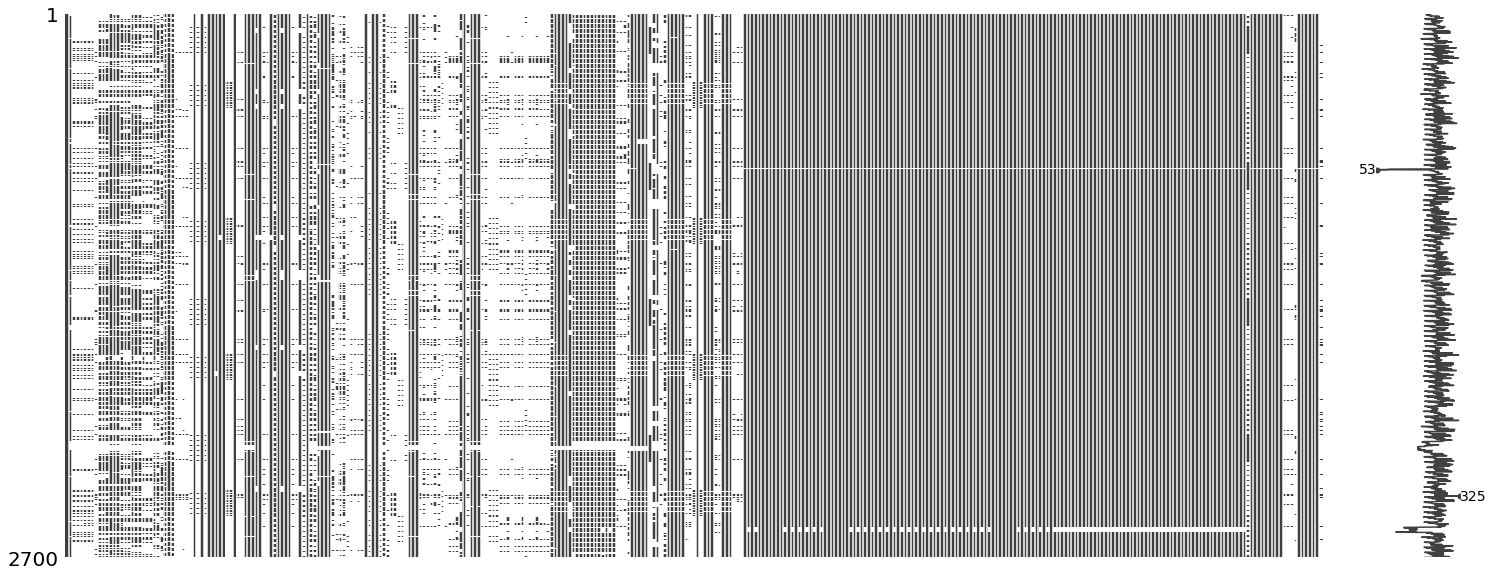

In [21]:
#Show missing values in matrix format using missingno package
msno.matrix(dataTransformedNaN)

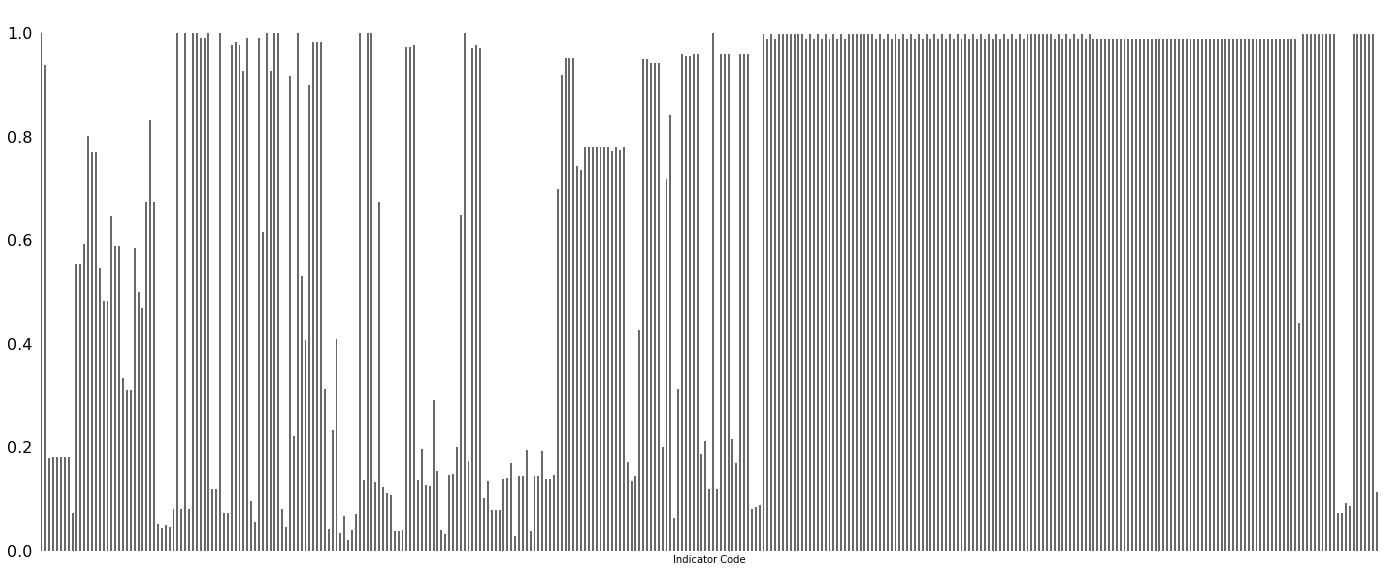

In [22]:
#show missing values in bar graph using missing no package
msno.bar(dataTransformedNaN)

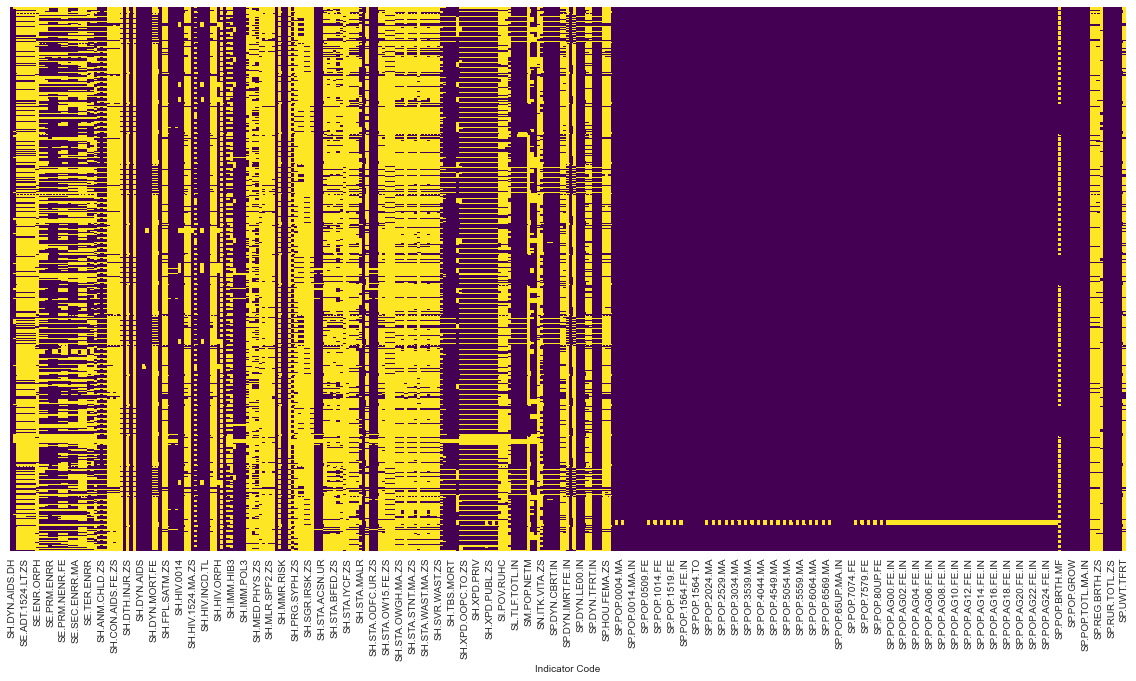

In [175]:
#Heat map to show missings values in features
plt.figure(figsize=(20,10))
sns.heatmap(df_cluster_std_selected, annot=True, cmap="Blues", linewidths=.5)
#sns.heatmap(dataTransformedNaN.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [25]:
#Count plot to count missing values w.r.t target variable
#sns.set_style('whitegrid')
#sns.countplot(x = y, data = dataTransformedNaN)

In [26]:
#Find column-wise missing values
dataTransformedNaN.isnull().sum()

Indicator Code
SH.DYN.AIDS.DH             0
NY.GNP.PCAP.CD           167
SE.ADT.1524.LT.FM.ZS    2214
SE.ADT.1524.LT.MA.ZS    2212
SE.ADT.1524.LT.ZS       2212
                        ... 
SP.RUR.TOTL.ZS             4
SP.URB.GROW                4
SP.URB.TOTL                4
SP.URB.TOTL.IN.ZS          4
SP.UWT.TFRT             2391
Length: 345, dtype: int64

## Feature wise missing value Percentage

In [27]:
#Find missing value Percentage
MissingColsPerc = dataTransformedNaN.isnull().mean().round(4) * 100
MissingColsPerc.head(20)                                    

Indicator Code
SH.DYN.AIDS.DH           0.00
NY.GNP.PCAP.CD           6.19
SE.ADT.1524.LT.FM.ZS    82.00
SE.ADT.1524.LT.MA.ZS    81.93
SE.ADT.1524.LT.ZS       81.93
SE.ADT.LITR.FE.ZS       81.81
SE.ADT.LITR.MA.ZS       81.81
SE.ADT.LITR.ZS          81.81
SE.ENR.ORPH             92.74
SE.PRM.CMPT.FE.ZS       44.63
SE.PRM.CMPT.MA.ZS       44.63
SE.PRM.CMPT.ZS          40.74
SE.PRM.ENRR             19.89
SE.PRM.ENRR.FE          23.00
SE.PRM.ENRR.MA          23.00
SE.PRM.NENR             45.41
SE.PRM.NENR.FE          51.70
SE.PRM.NENR.MA          51.70
SE.SEC.ENRR             35.26
SE.SEC.ENRR.FE          41.15
dtype: float64

In [28]:
#Identify features that have more than 30% missing values
missingCols = dataTransformedNaN.columns[dataTransformedNaN.isnull().mean().round(4) * 100 > 30]
print(len(missingCols))

116


### There are 176 columns which have more than 30% of missing data. So we drop these columns from our dataset as part of Data Preprocessing step

In [29]:
#Drop missing value columns
FeaturesExcludingMissingValues = dataTransformedNaN.drop(dataTransformedNaN[missingCols], axis = 1)
FeaturesExcludingMissingValues

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
143,100.0,NaN,28.684151,20.116831,36.673370,61.3,69482.0,101417.0,30537.0,500.0,23.605150,0.1,174.2,51.9,16.2,43.0,21.2,100.0,0.1,0.1,200.0,100.0,200.0,0.01,100.0,500.0,21.0,23.0,19.0,23.0,8700.0,10.0,9.870598,20.5,19.2,26.2,1330.0,38.1,16.0,34.0,95.0,191.0,44.0,344.0,13.0,NaN,Na

In [30]:
#Here is the shape of our dataset after removal of missing data ccolumns
FeaturesExcludingMissingValues.shape

(2700, 229)

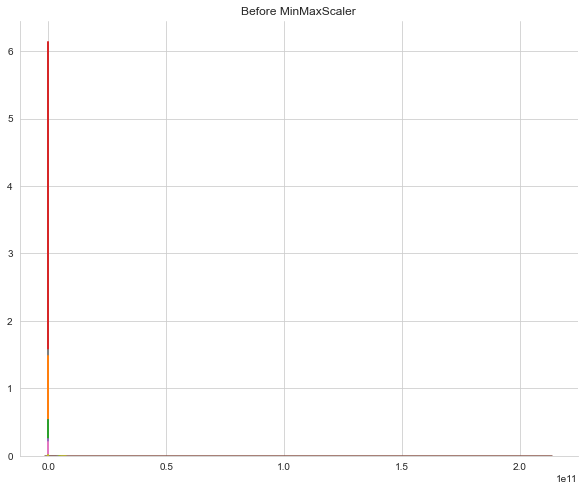

In [204]:
#Graph to show how data looks before normalization
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Before MinMaxScaler')
cols = FeaturesExcludingMissingValues.columns
for i in cols:
    sns.kdeplot(FeaturesExcludingMissingValues[i], ax=ax1, legend=False)
sns.despine()

## Data Normalization using MinMaxScaler
### As we have observed that data is scaled differently for each indicator, we are normalizing the data using MinMaxScalar and bring the data in range (0,1)

In [50]:
#Normalize features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
featuresNormalized = pd.DataFrame(scaler.fit_transform(FeaturesExcludingMissingValues), 
                                  columns = FeaturesExcludingMissingValues.columns)
featuresNormalized

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,0.000000,NaN,0.057695,0.123400,0.108111,0.639847,0.007998,0.008130,0.006135,0.000011,0.327638,0.000000,0.536118,0.719424,0.081140,0.249012,0.002532,0.000000,0.000000,0.000000,0.000033,0.000000,0.000029,0.000000,0.000000,0.000011,0.071429,0.208333,0.047619,0.164835,0.016665,0.00

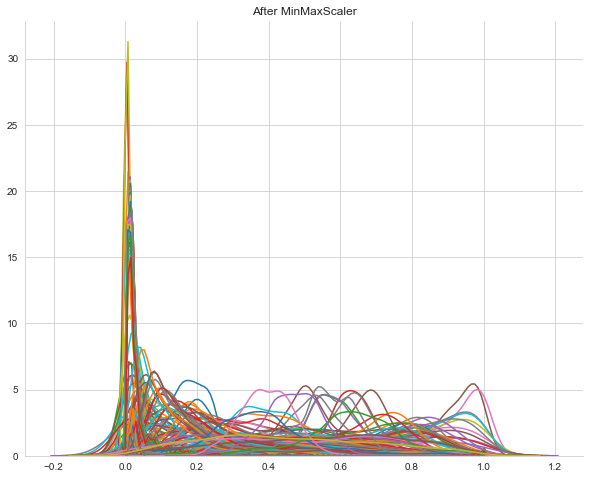

In [205]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('After MinMaxScaler')
cols = featuresNormalized.columns
for i in cols:
    sns.kdeplot(featuresNormalized[i], ax=ax1, legend=False)
sns.despine()

## KNN Imputer - 
### Each column's missing values are imputed using the mean value from n_neighbors nearest neighbors found in the dataset. Two samples are close, if the features that neither is missing are close.  By default, a euclidean distance metric that supports missings values, nan-eucliden_distances, is used to find the nearest neighbors

### After few trials, we concluded that K=5, is the best suitable value for missing value imputation

In [51]:
#Impute using K-NN Imputer
imputer = KNNImputer(n_neighbors = 5)

In [52]:
#Apply KNN Imputer and convert to DataFrame
featuresImputed = pd.DataFrame(np.array(imputer.fit_transform(featuresNormalized)), columns = featuresNormalized.columns)
featuresImputed

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,0.000000,0.005839,0.057695,0.123400,0.108111,0.639847,0.007998,0.008130,0.006135,0.000011,0.327638,0.000000,0.536118,0.719424,0.081140,0.249012,0.002532,0.000000,0.000000,0.000000,0.000033,0.000000,0.000029,0.000000,0.000000,0.000011,0.071429,0.208333,0.047619,0.164835,0.016665

In [53]:
featuresImputed.shape

(2700, 229)

### Here we see that all the missing values are filled using K-NN imputer, using missingno graphical representation

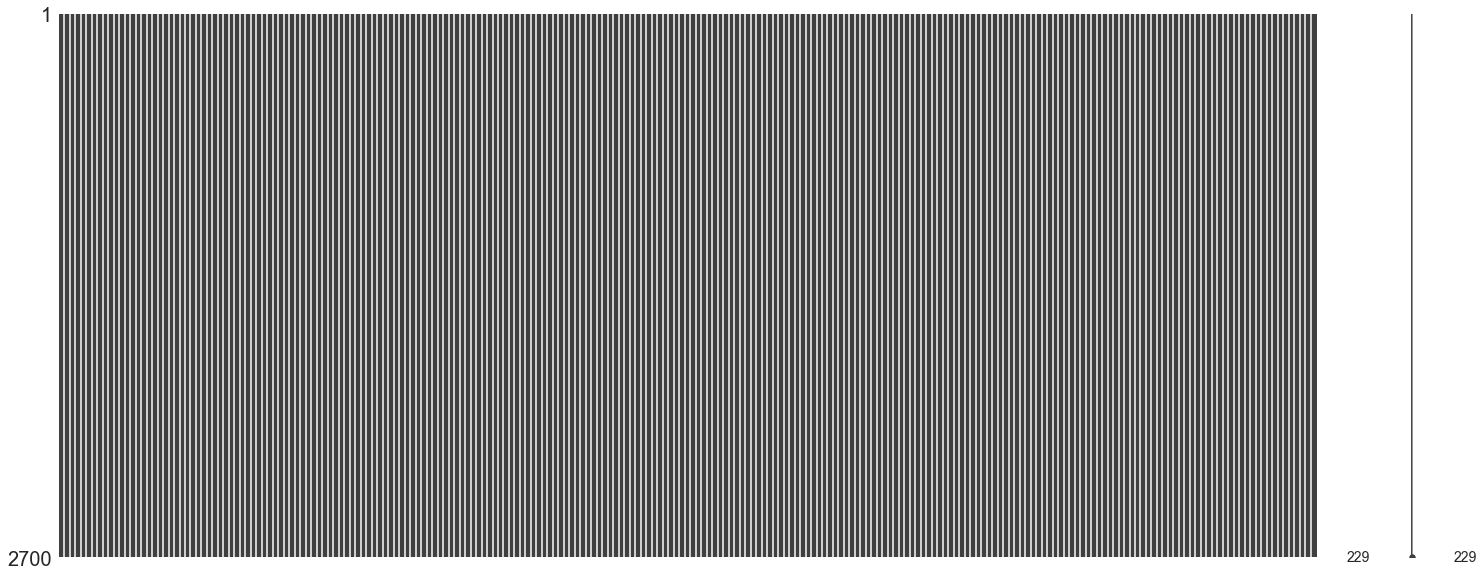

In [54]:
msno.matrix(featuresImputed)

In [55]:
featuresImputed.isna()

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [56]:
featuresImputed.isna().sum()

Indicator Code
SH.DYN.AIDS.DH       0
NY.GNP.PCAP.CD       0
SE.PRM.ENRR          0
SE.PRM.ENRR.FE       0
SE.PRM.ENRR.MA       0
                    ..
SP.RUR.TOTL.ZG       0
SP.RUR.TOTL.ZS       0
SP.URB.GROW          0
SP.URB.TOTL          0
SP.URB.TOTL.IN.ZS    0
Length: 229, dtype: int64

In [57]:
featuresImputed.head()

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
0,0.0,0.005839,0.057695,0.123400,0.108111,0.639847,0.007998,0.008130,0.006135,0.000011,0.327638,0.0,0.536118,0.719424,0.08114,0.249012,0.002532,0.0,0.0,0.0,0.000033,0.0,0.000029,0.0,0.000000,0.000011,0.071429,0.208333,0.047619,0.164835,0.016665,0.000169,0.598949,0.180412,0.192,0.

In [58]:
featuresImputed.shape

(2700, 229)

# Outlier Detection - Univariate
### Point Outliers - Observations anomalous with respect to the majority of observations in a feature aka Univariate outlier

# Z score and Outliers:
### Outlier is the observation which are far from the rest of the observations or the center of mass of observations.
### We are using Z-score to find such observations. If the z score of a data point is more than 3 Standard Deviations, it indicates that the data point is quite different from the other data points. Such a data point can be an outlier.

In [59]:
from scipy.stats import zscore
featuresUnivariate = stats.zscore(featuresImputed)
abs_z_scores = np.abs(featuresUnivariate)
#Univariate Outlier removal using Z Score
filtered_features = (abs_z_scores < 3).all(axis=1)
featuresUnivariateOutliers = featuresImputed[filtered_features]
featuresUnivariateOutliers

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
14,0.000050,0.002599,0.577053,0.469118,0.743869,0.393359,0.010212,0.010005,0.008840,0.000083,0.391297,0.000000,0.364636,0.572662,0.258772,0.492754,0.229114,0.000043,0.000000,0.000000,0.000133,0.000000,0.000114,0.000000,0.000107,0.000082,0.500000,0.572917,0.416667,0.549451,0.01704

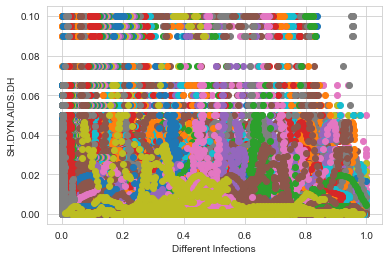

In [221]:
#Scatter plots before DBSCAN
cols2 = featuresUnivariateOutliers.columns
plt.xlabel("Different Infections")
plt.ylabel("SH.DYN.AIDS.DH")

for i in cols:
    plt.scatter(featuresUnivariateOutliers[i], featuresUnivariateOutliers['SH.DYN.AIDS.DH'], cmap="YIGnBU")
plt.show()    

# Multilayer outlier Analysis
### Multivariate outlier is the record having unusual combination of feature values. Clustering algorithms can be used for grouping similar data points present in unlabeled data and classify ungrouped data points as outlier. One such clustering technique is DBSCAN. Here we use DBSCAN to remove multivariate outliers.

### Here we consider cluster having label as '-1' is considered as outliers

In [60]:
#Multivariate Outlier removal using DBSCAN
from sklearn.cluster import DBSCAN
from collections import Counter

In [61]:
DBmodel = DBSCAN(eps = 0.8, min_samples = 19).fit(featuresUnivariateOutliers)

In [62]:
outliers_df = pd.DataFrame(featuresUnivariateOutliers)
print(Counter(DBmodel.labels_))

Counter({-1: 1006, 2: 284, 3: 59, 10: 48, 1: 36, 11: 33, 16: 30, 0: 25, 13: 25, 14: 25, 15: 24, 8: 23, 5: 21, 6: 21, 7: 21, 4: 19, 12: 19, 9: 18, 17: 18})


In [63]:
#Features excluding outliers
MVOutliers = outliers_df[DBmodel.labels_ == -1].values
dfExcludingOutliers = outliers_df[DBmodel.labels_ != -1]
print(len(MVOutliers))
print(len(dfExcludingOutliers))

1006
749


In [64]:
dfExcludingOutliers

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DTH.MORT,SH.DTH.NMRT,SH.DYN.AIDS,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.DYN.NMRT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.TL,SH.HIV.INCD.ZS,SH.HIV.ORPH,SH.HIV.TOTL,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.IMM.POL3,SH.MMR.DTHS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ACSN.RU,SH.STA.ACSN.UR,SH.STA.MMRT,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.TBS.PREV,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.DYN.IMRT.IN,SP.DYN.LE00.FE.IN,SP.DYN.LE00.IN,SP.DYN.LE00.MA.IN,SP.DYN.TFRT.IN,SP.DYN.TO65.FE.ZS,SP.DYN.TO65.MA.ZS,SP.POP.0004.FE,SP.POP.0004.FE.5Y,SP.POP.0004.MA,SP.POP.0004.MA.5Y,SP.POP.0014.FE.IN,SP.POP.0014.FE.ZS,SP.POP.0014.MA.IN,SP.POP.0014.MA.ZS,SP.POP.0014.TO,SP.POP.0014.TO.ZS,SP.POP.0509.FE,SP.POP.0509.FE.5Y,SP.POP.0509.MA,SP.POP.0509.MA.5Y,SP.POP.1014.FE,SP.POP.1014.FE.5Y,SP.POP.1014.MA,SP.POP.1014.MA.5Y,SP.POP.1519.FE,SP.POP.1519.FE.5Y,SP.POP.1519.MA,SP.POP.1519.MA.5Y,SP.POP.1564.FE.IN,SP.POP.1564.FE.ZS,SP.POP.1564.MA.IN,SP.POP.1564.MA.ZS,SP.POP.1564.TO,SP.POP.1564.TO.ZS,SP.POP.2024.FE,SP.POP.2024.FE.5Y,SP.POP.2024.MA,SP.POP.2024.MA.5Y,SP.POP.2529.FE,SP.POP.2529.FE.5Y,SP.POP.2529.MA,SP.POP.2529.MA.5Y,SP.POP.3034.FE,SP.POP.3034.FE.5Y,SP.POP.3034.MA,SP.POP.3034.MA.5Y,SP.POP.3539.FE,SP.POP.3539.FE.5Y,SP.POP.3539.MA,SP.POP.3539.MA.5Y,SP.POP.4044.FE,SP.POP.4044.FE.5Y,SP.POP.4044.MA,SP.POP.4044.MA.5Y,SP.POP.4549.FE,SP.POP.4549.FE.5Y,SP.POP.4549.MA,SP.POP.4549.MA.5Y,SP.POP.5054.FE,SP.POP.5054.FE.5Y,SP.POP.5054.MA,SP.POP.5054.MA.5Y,SP.POP.5559.FE,SP.POP.5559.FE.5Y,SP.POP.5559.MA,SP.POP.5559.MA.5Y,SP.POP.6064.FE,SP.POP.6064.FE.5Y,SP.POP.6064.MA,SP.POP.6064.MA.5Y,SP.POP.6569.FE,SP.POP.6569.FE.5Y,SP.POP.6569.MA,SP.POP.6569.MA.5Y,SP.POP.65UP.FE.IN,SP.POP.65UP.FE.ZS,SP.POP.65UP.MA.IN,SP.POP.65UP.MA.ZS,SP.POP.65UP.TO,SP.POP.65UP.TO.ZS,SP.POP.7074.FE,SP.POP.7074.FE.5Y,SP.POP.7074.MA,SP.POP.7074.MA.5Y,SP.POP.7579.FE,SP.POP.7579.FE.5Y,SP.POP.7579.MA,SP.POP.7579.MA.5Y,SP.POP.80UP.FE,SP.POP.80UP.FE.5Y,SP.POP.80UP.MA,SP.POP.80UP.MA.5Y,SP.POP.AG00.FE.IN,SP.POP.AG00.MA.IN,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.POP.AG06.FE.IN,SP.POP.AG06.MA.IN,SP.POP.AG07.FE.IN,SP.POP.AG07.MA.IN,SP.POP.AG08.FE.IN,SP.POP.AG08.MA.IN,SP.POP.AG09.FE.IN,SP.POP.AG09.MA.IN,SP.POP.AG10.FE.IN,SP.POP.AG10.MA.IN,SP.POP.AG11.FE.IN,SP.POP.AG11.MA.IN,SP.POP.AG12.FE.IN,SP.POP.AG12.MA.IN,SP.POP.AG13.FE.IN,SP.POP.AG13.MA.IN,SP.POP.AG14.FE.IN,SP.POP.AG14.MA.IN,SP.POP.AG15.FE.IN,SP.POP.AG15.MA.IN,SP.POP.AG16.FE.IN,SP.POP.AG16.MA.IN,SP.POP.AG17.FE.IN,SP.POP.AG17.MA.IN,SP.POP.AG18.FE.IN,SP.POP.AG18.MA.IN,SP.POP.AG19.FE.IN,SP.POP.AG19.MA.IN,SP.POP.AG20.FE.IN,SP.POP.AG20.MA.IN,SP.POP.AG21.FE.IN,SP.POP.AG21.MA.IN,SP.POP.AG22.FE.IN,SP.POP.AG22.MA.IN,SP.POP.AG23.FE.IN,SP.POP.AG23.MA.IN,SP.POP.AG24.FE.IN,SP.POP.AG24.MA.IN,SP.POP.AG25.FE.IN,SP.POP.AG25.MA.IN,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,SP.POP.GROW,SP.POP.TOTL,SP.POP.TOTL.FE.IN,SP.POP.TOTL.FE.ZS,SP.POP.TOTL.MA.IN,SP.POP.TOTL.MA.ZS,SP.RUR.TOTL,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW,SP.URB.TOTL,SP.URB.TOTL.IN.ZS
50,0.00045,0.059156,0.610864,0.665750,0.603118,0.259259,0.002044,0.001593,0.002264,0.000857,0.418939,0.003484,0.072550,0.188489,0.671053,0.968379,0.925316,0.000174,0.000000,0.011236,0.001767,0.0002,0.001571,0.004132,0.000073,0.000842,1.000000,0.802083,1.000000,0.857143,0.000975,0

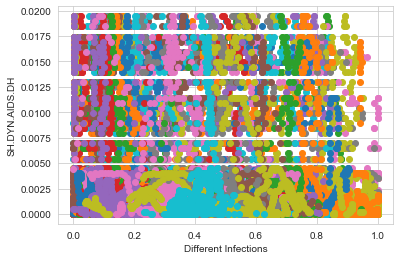

In [222]:
cols = featuresExcludingOutliers.columns.values[1:]
plt.xlabel("Different Infections")
plt.ylabel("SH.DYN.AIDS.DH")

for i in cols:
    plt.scatter(dfExcludingOutliers[i], dfExcludingOutliers['SH.DYN.AIDS.DH'], cmap="YIGnBU")
plt.show()    

# Correlation:
### Correlation is a statistical term which in common usage refers to how close two variables are to having a linear relationship with each other. Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features. Hence using this method, we have dropped the features having more than 95% absolute correlation.

In [68]:
#Find Correlation amongs features and eliminate features that have more 95% correlation
features_ImputedCorr = dfExcludingOutliers.corr().abs()
upper = features_ImputedCorr.where(np.triu(np.ones(features_ImputedCorr.shape), k = 1).astype(np.bool))
dropUpper = [column for column in upper.columns if any(upper[column] > 0.95)]

In [69]:
#Drop features that have more 95% correlation
featuresExcludingOutliers = dfExcludingOutliers.drop(features_ImputedCorr[dropUpper], axis = 1)
featuresExcludingOutliers

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.ZS,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.POP.1014.FE.5Y,SP.POP.1519.FE.5Y,SP.POP.2024.FE.5Y,SP.POP.2024.MA.5Y,SP.POP.2529.FE.5Y,SP.POP.2529.MA.5Y,SP.POP.3034.FE.5Y,SP.POP.3539.FE.5Y,SP.POP.4044.FE.5Y,SP.POP.4549.FE.5Y,SP.POP.5054.FE.5Y,SP.POP.5559.FE.5Y,SP.POP.6064.FE.5Y,SP.POP.6569.FE.5Y,SP.POP.GROW,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS,SP.URB.GROW
50,0.00045,0.059156,0.610864,0.259259,0.002044,0.418939,0.003484,0.072550,0.671053,0.968379,0.925316,0.000174,0.000000,0.011236,0.001767,0.0002,0.004132,1.000000,0.802083,1.000000,0.018739,0.013090,0.875258,0.013,0.022936,0.016704,0.233333,0.031846,0.017593,0.868085,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.558623,0.003957,0.113106,0.161094,0.000117,0.0,0.302747,0.084191,0.188418,0.294763,0.118778,0.533988,0.487894,0.316159,0.350837,0.284263,0.303717,0.294918,0.409294,0.450093,0.418769,0.399682,0.427012,0.441327,0.437481,0.540842,0.471490,0.346353,0.088878,0.360547
51,0.00045,0.094772,0.628570,0.236271,0.001969,0.421564,0.003484,0.069724,0.685307,0.968379,0.927848,0.000174,0.000000,0.011236,0.001800,0.0002,0.004132,1.000000,0.812500,0.916667,0.019583,0.012544,0.879381,0.013,0.022936,0.016704,0.236111,0.031846,0.016204,0.868085,0.000501,0.283994,0.625848,0.104769,0.177782,0.439250,0.326676,0.576608,0.421800,0.117223,0.560246,0.556445,0.004001,0.114901,0.203647,0.000117,0.0,0.302568,0.081886,0.184670,0.289774,0.117038,0.519433,0.510965,0.321293,0.356313,0.278609,0.299420,0.289789,0.406506,0.456394,0.424336,0.399608,0.419178,0.434648,0.441446,0.538865,0.472846,0.397175,0.086495,0.353330
52,0.00060,0.106848,0.622123,0.213282,0.001884,0.423964,0.003484,0.066897,0.698465,0.969697,0.931646,0.000174,0.000000,0.011236,0.001800,0.0002,0.004132,1.000000,0.812500,0.952381,0.021271,0.011567,0.883505,0.013,0.022936,0.016704,0.258333,0.031846,0.016667,0.889362,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.563320,0.004064,0.236984,0.249240,0.000117,0.0,0.299504,0.080178,0.180199,0.284111,0.115269,0.499359,0.534271,0.329810,0.365457,0.274672,0.297144,0.285386,0.402785,0.462573,0.431068,0.401813,0.413064,0.427440,0.445461,0.536437,0.473785,0.395478,0.084157,0.351712
53,0.00075,0.114032,0.630526,0.194125,0.001794,0.426138,0.003484,0.064698,0.712719,0.969697,0.935443,0.000391,0.000000,0.011236,0.001800,0.0008,0.004132,1.000000,0.822917,0.964286,0.022115,0.011220,0.887629,0.013,0.022936,0.016704,0.252778,0.031846,0.014815,0.900000,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.566827,0.004131,0.260323,0.322188,0.000117,0.0,0.296439,0.078470,0.175727,0.277944,0.113557,0.479619,0.550378,0.342480,0.379929,0.273168,0.297221,0.280866,0.398344,0.467329,0.438150,0.405498,0.408751,0.420375,0.448050,0.533463,0.474766,0.392503,0.081841,0.349871
54,0.00085,0.110822,0.631710,0.177522,0.001716,0.427886,0.006969,0.062500,0.725877,0.971014,0.937975,0.000391,0.000000,0.011236,0.001800,0.0008,0.004132,1.000000,0.854167,1.000000,0.023381,0.010679,0.891753,0.013,0.022936,0.016704,0.247222,0.031107,0.015278,0.857447,0.000158,0.272333,0.676714,0.093421,0.147114,0.388606,0.273119,0.625424,0.437908,0.100889,0.530344,

In [70]:
featuresExcludingOutliers.columns

Index(['SH.DYN.AIDS.DH', 'NY.GNP.PCAP.CD', 'SE.PRM.ENRR', 'SH.ANM.CHLD.ZS',
       'SH.DTH.IMRT', 'SH.DYN.AIDS.FE.ZS', 'SH.DYN.AIDS.ZS', 'SH.DYN.MORT',
       'SH.H2O.SAFE.RU.ZS', 'SH.H2O.SAFE.UR.ZS', 'SH.H2O.SAFE.ZS',
       'SH.HIV.0014', 'SH.HIV.1524.FE.ZS', 'SH.HIV.1524.MA.ZS', 'SH.HIV.INCD',
       'SH.HIV.INCD.14', 'SH.HIV.INCD.ZS', 'SH.IMM.IBCG', 'SH.IMM.IDPT',
       'SH.IMM.MEAS', 'SH.MMR.RISK', 'SH.MMR.RISK.ZS', 'SH.STA.ACSN',
       'SH.STA.ODFC.RU.ZS', 'SH.STA.ODFC.UR.ZS', 'SH.STA.ODFC.ZS',
       'SH.TBS.DTEC.ZS', 'SH.TBS.INCD', 'SH.TBS.MORT', 'SH.VAC.TTNS.ZS',
       'SH.XPD.EXTR.ZS', 'SH.XPD.OOPC.TO.ZS', 'SH.XPD.OOPC.ZS', 'SH.XPD.PCAP',
       'SH.XPD.PCAP.PP.KD', 'SH.XPD.PRIV', 'SH.XPD.PRIV.ZS',
       'SH.XPD.PUBL.GX.ZS', 'SH.XPD.PUBL.ZS', 'SH.XPD.TOTL.CD',
       'SH.XPD.TOTL.ZS', 'SL.TLF.TOTL.FE.ZS', 'SL.TLF.TOTL.IN',
       'SL.UEM.TOTL.FE.ZS', 'SL.UEM.TOTL.MA.ZS', 'SN.ITK.DEFC',
       'SN.ITK.DEFC.ZS', 'SP.ADO.TFRT', 'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA',
       'SP.

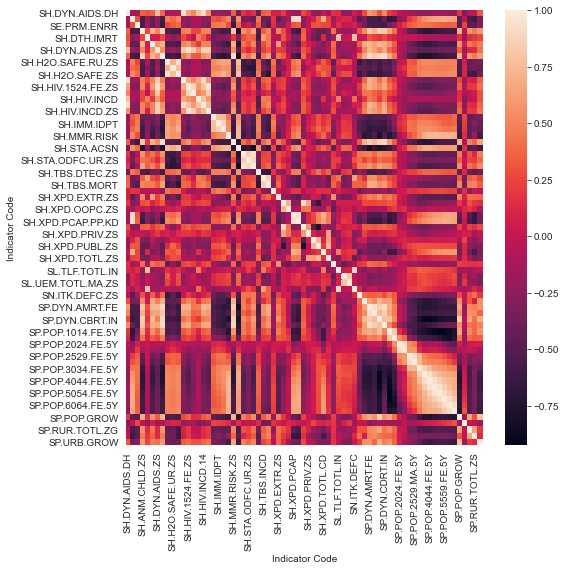

In [212]:
#Draw corelation matrix
plt.figure(figsize=(8,8))
corrMatrix = featuresExcludingOutliers.corr()
sns.heatmap(corrMatrix)

# Descriptive Statistics

In [73]:
featuresExcludingOutliers.columns

Index(['SH.DYN.AIDS.DH', 'NY.GNP.PCAP.CD', 'SE.PRM.ENRR', 'SH.ANM.CHLD.ZS',
       'SH.DTH.IMRT', 'SH.DYN.AIDS.FE.ZS', 'SH.DYN.AIDS.ZS', 'SH.DYN.MORT',
       'SH.H2O.SAFE.RU.ZS', 'SH.H2O.SAFE.UR.ZS', 'SH.H2O.SAFE.ZS',
       'SH.HIV.0014', 'SH.HIV.1524.FE.ZS', 'SH.HIV.1524.MA.ZS', 'SH.HIV.INCD',
       'SH.HIV.INCD.14', 'SH.HIV.INCD.ZS', 'SH.IMM.IBCG', 'SH.IMM.IDPT',
       'SH.IMM.MEAS', 'SH.MMR.RISK', 'SH.MMR.RISK.ZS', 'SH.STA.ACSN',
       'SH.STA.ODFC.RU.ZS', 'SH.STA.ODFC.UR.ZS', 'SH.STA.ODFC.ZS',
       'SH.TBS.DTEC.ZS', 'SH.TBS.INCD', 'SH.TBS.MORT', 'SH.VAC.TTNS.ZS',
       'SH.XPD.EXTR.ZS', 'SH.XPD.OOPC.TO.ZS', 'SH.XPD.OOPC.ZS', 'SH.XPD.PCAP',
       'SH.XPD.PCAP.PP.KD', 'SH.XPD.PRIV', 'SH.XPD.PRIV.ZS',
       'SH.XPD.PUBL.GX.ZS', 'SH.XPD.PUBL.ZS', 'SH.XPD.TOTL.CD',
       'SH.XPD.TOTL.ZS', 'SL.TLF.TOTL.FE.ZS', 'SL.TLF.TOTL.IN',
       'SL.UEM.TOTL.FE.ZS', 'SL.UEM.TOTL.MA.ZS', 'SN.ITK.DEFC',
       'SN.ITK.DEFC.ZS', 'SP.ADO.TFRT', 'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA',
       'SP.

<Figure size 864x864 with 0 Axes>

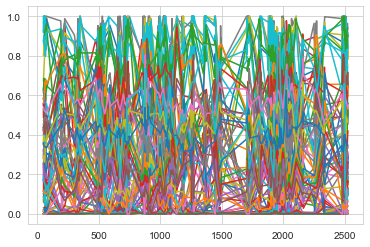

In [210]:
plt.figure(figsize=(12,12))
featuresExcludingOutliers.plot.line(legend = False)

[]

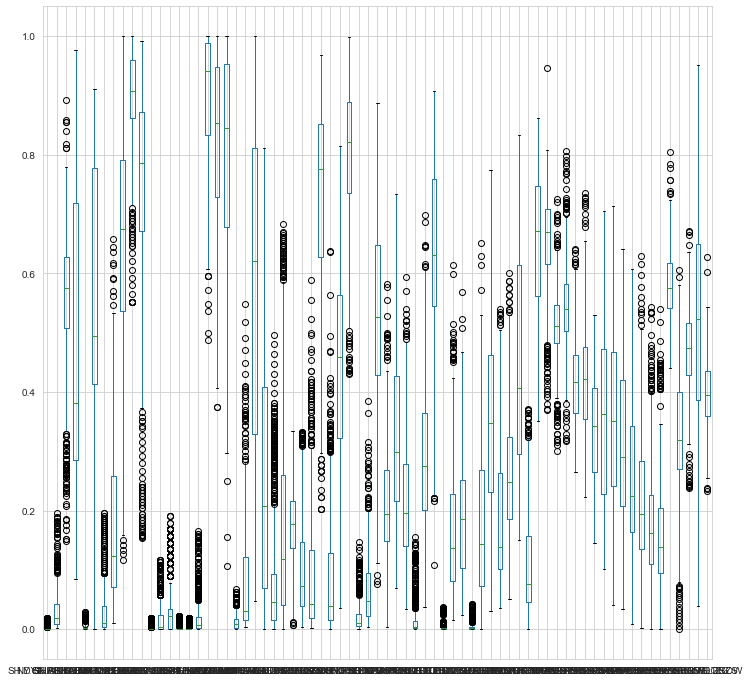

In [207]:
plt.figure(figsize=(12,12))
featuresExcludingOutliers.boxplot(return_type='dict')
plt.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14c0796d0>,
      dtype=object)

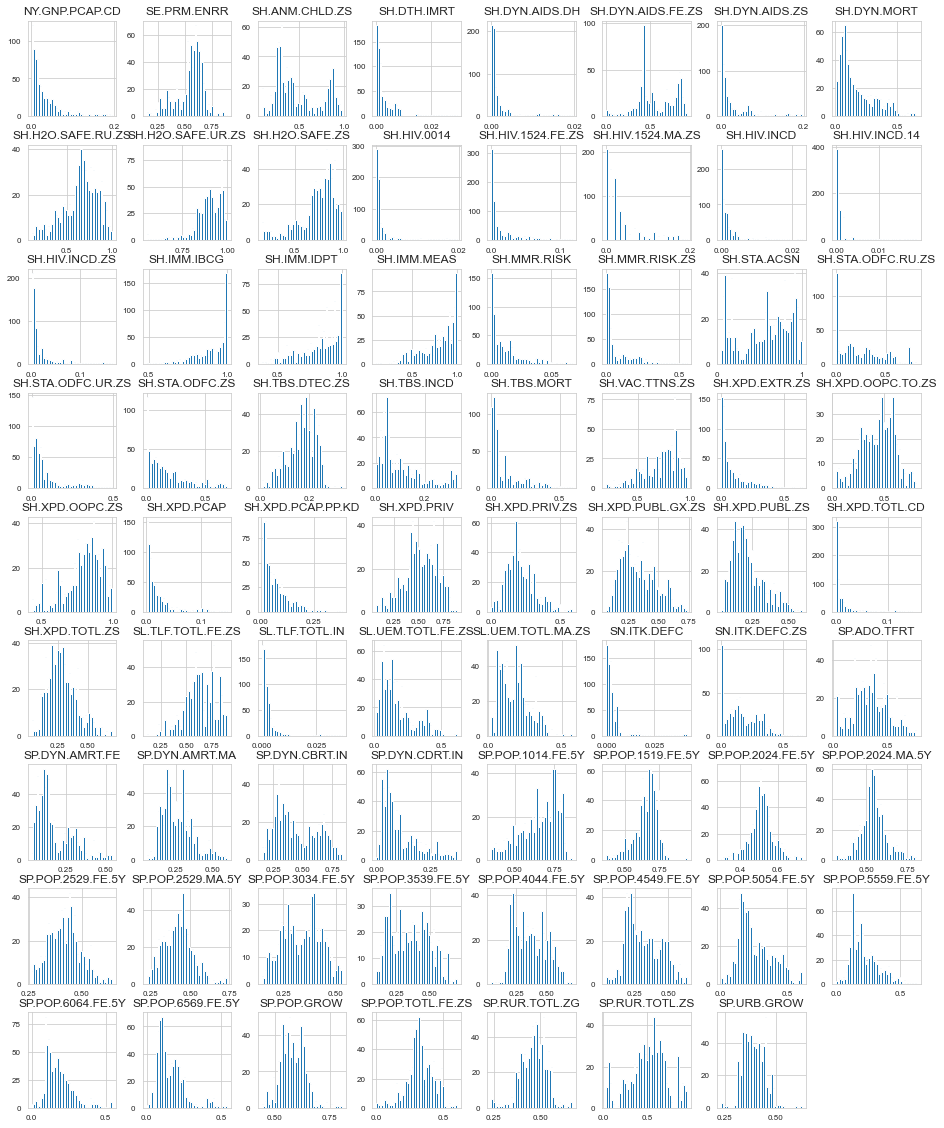

In [77]:
#Pair plots for features
featuresExcludingOutliers.hist(figsize=(16,20), bins =50, xlabelsize=8, ylabelsize=8)

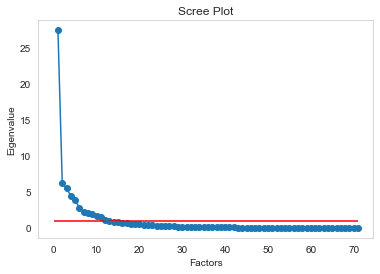

In [217]:
#Perform Factor Analysis
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer()
fa.fit(featuresExcludingOutliers, 25)

ev, v = fa.get_eigenvalues()

# Create scree plot using matplotlib
plt.figure(figsize=(6,4))
plt.scatter(range(1,featuresExcludingOutliers.shape[1]+1),ev)
plt.plot(range(1,featuresExcludingOutliers.shape[1]+1),ev)
plt.hlines(1, 0, featuresExcludingOutliers.shape[1], colors='r')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [220]:
#Perform Factor Analysis
fa = FactorAnalyzer(list(ev >= 0.95).count(True), rotation='varimax')
fa.fit(featuresExcludingOutliers)
loads = fa.loadings_
print(loads)

[[-7.08306216e-02  8.53203221e-01  6.09662519e-02  7.06775453e-02
   2.15049186e-01 -5.90770286e-03  1.74569611e-01  5.37532850e-02
  -3.85207528e-02  2.19637978e-02 -1.52761272e-01 -2.34399069e-01]
 [ 5.91134396e-01 -6.49991631e-02 -8.35670312e-02 -1.34889789e-01
  -1.58426321e-01  6.62407848e-01  5.14089044e-02 -7.75348163e-02
  -5.99738766e-02  4.96027020e-02 -4.12904782e-02 -8.47026886e-02]
 [ 2.90437760e-01 -1.06470501e-01 -6.54705312e-01  1.22530481e-01
   1.66799028e-02  1.20349239e-01  1.84438180e-01 -1.76631438e-02
   1.73221297e-01  2.04314281e-01 -1.09371307e-01  2.11369888e-01]
 [-5.30334292e-01  3.19006582e-01  5.02185362e-01  3.54917654e-01
   2.68297597e-03 -1.79529947e-01  4.93766408e-02  4.77495527e-04
  -1.12290459e-01 -2.17213624e-01 -4.77965234e-02  8.45485067e-02]
 [-7.86434674e-02  1.15924631e-01  1.22289368e-01  1.95105512e-01
   8.50905932e-01 -2.67374963e-02 -3.06071972e-03  1.67599474e-01
   1.52583853e-02 -1.73141608e-01  7.82823127e-02 -9.23094668e-02]
 [-4.

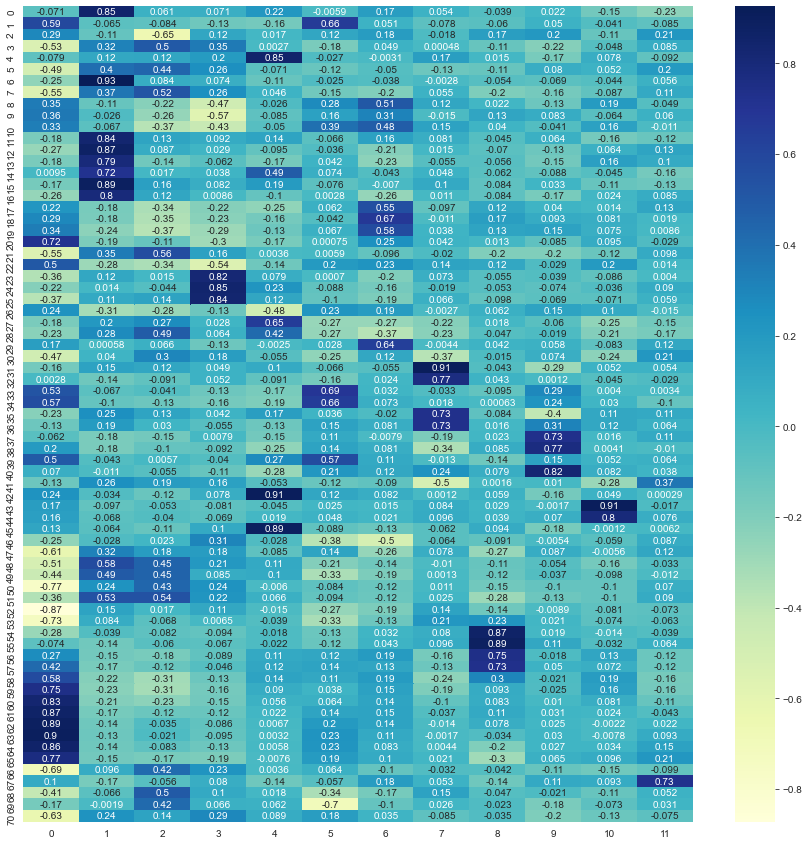

In [219]:
#Heatmap of loadings
plt.figure(figsize=(15,15))
sns.heatmap(loads, annot=True, cmap="YlGnBu")

# Feature Extraction
### We have selected features based on their importance. We have calculated importance, using linear regression. Using this we get negative and positive affiliation on target variable. Here we can consider features with positive importance

In [79]:
featuresExcludingOutliers.shape

(749, 71)

In [80]:
y = featuresExcludingOutliers['SH.DYN.AIDS.DH']
X = featuresExcludingOutliers.drop(['SH.DYN.AIDS.DH'], axis = 1)

In [81]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
modelLR = LinearRegression()
a = modelLR.fit(X,y)

In [82]:
#get importance
importance = modelLR.coef_
#Summarize feature importance
a = []
for i,v in enumerate(importance):
    a.append(v)
    print('Feature: %0d, Score: %.5f' %(i,v))
#print(a)
#type(a)  


Feature: 0, Score: 0.00628
Feature: 1, Score: -0.00016
Feature: 2, Score: 0.00047
Feature: 3, Score: -0.09953
Feature: 4, Score: -0.00012
Feature: 5, Score: 0.00672
Feature: 6, Score: 0.00102
Feature: 7, Score: -0.00406
Feature: 8, Score: -0.00232
Feature: 9, Score: 0.00602
Feature: 10, Score: 0.57741
Feature: 11, Score: -0.00928
Feature: 12, Score: 0.01022
Feature: 13, Score: 0.06768
Feature: 14, Score: 0.33107
Feature: 15, Score: -0.02600
Feature: 16, Score: -0.00036
Feature: 17, Score: -0.00013
Feature: 18, Score: 0.00051
Feature: 19, Score: 0.02224
Feature: 20, Score: -0.00090
Feature: 21, Score: 0.00069
Feature: 22, Score: -0.00563
Feature: 23, Score: -0.00422
Feature: 24, Score: 0.01146
Feature: 25, Score: -0.00052
Feature: 26, Score: 0.00242
Feature: 27, Score: 0.00386
Feature: 28, Score: 0.00005
Feature: 29, Score: -0.00025
Feature: 30, Score: -0.00216
Feature: 31, Score: 0.00106
Feature: 32, Score: -0.00372
Feature: 33, Score: 0.00116
Feature: 34, Score: 0.00205
Feature: 35, S

In [83]:
coef_dict = {}
for coef, feat in zip(modelLR.coef_,featuresExcludingOutliers.columns):
    coef_dict[feat] = coef

In [84]:
pn = pd.DataFrame.from_dict(coef_dict, orient = 'index')
pn.columns = ['Imp']
pn.index

Index(['SH.DYN.AIDS.DH', 'NY.GNP.PCAP.CD', 'SE.PRM.ENRR', 'SH.ANM.CHLD.ZS',
       'SH.DTH.IMRT', 'SH.DYN.AIDS.FE.ZS', 'SH.DYN.AIDS.ZS', 'SH.DYN.MORT',
       'SH.H2O.SAFE.RU.ZS', 'SH.H2O.SAFE.UR.ZS', 'SH.H2O.SAFE.ZS',
       'SH.HIV.0014', 'SH.HIV.1524.FE.ZS', 'SH.HIV.1524.MA.ZS', 'SH.HIV.INCD',
       'SH.HIV.INCD.14', 'SH.HIV.INCD.ZS', 'SH.IMM.IBCG', 'SH.IMM.IDPT',
       'SH.IMM.MEAS', 'SH.MMR.RISK', 'SH.MMR.RISK.ZS', 'SH.STA.ACSN',
       'SH.STA.ODFC.RU.ZS', 'SH.STA.ODFC.UR.ZS', 'SH.STA.ODFC.ZS',
       'SH.TBS.DTEC.ZS', 'SH.TBS.INCD', 'SH.TBS.MORT', 'SH.VAC.TTNS.ZS',
       'SH.XPD.EXTR.ZS', 'SH.XPD.OOPC.TO.ZS', 'SH.XPD.OOPC.ZS', 'SH.XPD.PCAP',
       'SH.XPD.PCAP.PP.KD', 'SH.XPD.PRIV', 'SH.XPD.PRIV.ZS',
       'SH.XPD.PUBL.GX.ZS', 'SH.XPD.PUBL.ZS', 'SH.XPD.TOTL.CD',
       'SH.XPD.TOTL.ZS', 'SL.TLF.TOTL.FE.ZS', 'SL.TLF.TOTL.IN',
       'SL.UEM.TOTL.FE.ZS', 'SL.UEM.TOTL.MA.ZS', 'SN.ITK.DEFC',
       'SN.ITK.DEFC.ZS', 'SP.ADO.TFRT', 'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA',
       'SP.

In [85]:
print(type(pn))
featuresSemiFinal = pn.index.to_list()
type(featuresSemiFinal)

<class 'pandas.core.frame.DataFrame'>


list

In [86]:
featuresExcludingOutliers[featuresSemiFinal]

Indicator Code,SH.DYN.AIDS.DH,NY.GNP.PCAP.CD,SE.PRM.ENRR,SH.ANM.CHLD.ZS,SH.DTH.IMRT,SH.DYN.AIDS.FE.ZS,SH.DYN.AIDS.ZS,SH.DYN.MORT,SH.H2O.SAFE.RU.ZS,SH.H2O.SAFE.UR.ZS,SH.H2O.SAFE.ZS,SH.HIV.0014,SH.HIV.1524.FE.ZS,SH.HIV.1524.MA.ZS,SH.HIV.INCD,SH.HIV.INCD.14,SH.HIV.INCD.ZS,SH.IMM.IBCG,SH.IMM.IDPT,SH.IMM.MEAS,SH.MMR.RISK,SH.MMR.RISK.ZS,SH.STA.ACSN,SH.STA.ODFC.RU.ZS,SH.STA.ODFC.UR.ZS,SH.STA.ODFC.ZS,SH.TBS.DTEC.ZS,SH.TBS.INCD,SH.TBS.MORT,SH.VAC.TTNS.ZS,SH.XPD.EXTR.ZS,SH.XPD.OOPC.TO.ZS,SH.XPD.OOPC.ZS,SH.XPD.PCAP,SH.XPD.PCAP.PP.KD,SH.XPD.PRIV,SH.XPD.PRIV.ZS,SH.XPD.PUBL.GX.ZS,SH.XPD.PUBL.ZS,SH.XPD.TOTL.CD,SH.XPD.TOTL.ZS,SL.TLF.TOTL.FE.ZS,SL.TLF.TOTL.IN,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SN.ITK.DEFC,SN.ITK.DEFC.ZS,SP.ADO.TFRT,SP.DYN.AMRT.FE,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,SP.DYN.CDRT.IN,SP.POP.1014.FE.5Y,SP.POP.1519.FE.5Y,SP.POP.2024.FE.5Y,SP.POP.2024.MA.5Y,SP.POP.2529.FE.5Y,SP.POP.2529.MA.5Y,SP.POP.3034.FE.5Y,SP.POP.3539.FE.5Y,SP.POP.4044.FE.5Y,SP.POP.4549.FE.5Y,SP.POP.5054.FE.5Y,SP.POP.5559.FE.5Y,SP.POP.6064.FE.5Y,SP.POP.6569.FE.5Y,SP.POP.GROW,SP.POP.TOTL.FE.ZS,SP.RUR.TOTL.ZG,SP.RUR.TOTL.ZS
50,0.00045,0.059156,0.610864,0.259259,0.002044,0.418939,0.003484,0.072550,0.671053,0.968379,0.925316,0.000174,0.000000,0.011236,0.001767,0.0002,0.004132,1.000000,0.802083,1.000000,0.018739,0.013090,0.875258,0.013,0.022936,0.016704,0.233333,0.031846,0.017593,0.868085,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.558623,0.003957,0.113106,0.161094,0.000117,0.0,0.302747,0.084191,0.188418,0.294763,0.118778,0.533988,0.487894,0.316159,0.350837,0.284263,0.303717,0.294918,0.409294,0.450093,0.418769,0.399682,0.427012,0.441327,0.437481,0.540842,0.471490,0.346353,0.088878
51,0.00045,0.094772,0.628570,0.236271,0.001969,0.421564,0.003484,0.069724,0.685307,0.968379,0.927848,0.000174,0.000000,0.011236,0.001800,0.0002,0.004132,1.000000,0.812500,0.916667,0.019583,0.012544,0.879381,0.013,0.022936,0.016704,0.236111,0.031846,0.016204,0.868085,0.000501,0.283994,0.625848,0.104769,0.177782,0.439250,0.326676,0.576608,0.421800,0.117223,0.560246,0.556445,0.004001,0.114901,0.203647,0.000117,0.0,0.302568,0.081886,0.184670,0.289774,0.117038,0.519433,0.510965,0.321293,0.356313,0.278609,0.299420,0.289789,0.406506,0.456394,0.424336,0.399608,0.419178,0.434648,0.441446,0.538865,0.472846,0.397175,0.086495
52,0.00060,0.106848,0.622123,0.213282,0.001884,0.423964,0.003484,0.066897,0.698465,0.969697,0.931646,0.000174,0.000000,0.011236,0.001800,0.0002,0.004132,1.000000,0.812500,0.952381,0.021271,0.011567,0.883505,0.013,0.022936,0.016704,0.258333,0.031846,0.016667,0.889362,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.563320,0.004064,0.236984,0.249240,0.000117,0.0,0.299504,0.080178,0.180199,0.284111,0.115269,0.499359,0.534271,0.329810,0.365457,0.274672,0.297144,0.285386,0.402785,0.462573,0.431068,0.401813,0.413064,0.427440,0.445461,0.536437,0.473785,0.395478,0.084157
53,0.00075,0.114032,0.630526,0.194125,0.001794,0.426138,0.003484,0.064698,0.712719,0.969697,0.935443,0.000391,0.000000,0.011236,0.001800,0.0008,0.004132,1.000000,0.822917,0.964286,0.022115,0.011220,0.887629,0.013,0.022936,0.016704,0.252778,0.031846,0.014815,0.900000,0.000501,0.281694,0.639728,0.101897,0.168984,0.426614,0.309661,0.588918,0.421811,0.112758,0.546313,0.566827,0.004131,0.260323,0.322188,0.000117,0.0,0.296439,0.078470,0.175727,0.277944,0.113557,0.479619,0.550378,0.342480,0.379929,0.273168,0.297221,0.280866,0.398344,0.467329,0.438150,0.405498,0.408751,0.420375,0.448050,0.533463,0.474766,0.392503,0.081841
54,0.00085,0.110822,0.631710,0.177522,0.001716,0.427886,0.006969,0.062500,0.725877,0.971014,0.937975,0.000391,0.000000,0.011236,0.001800,0.0008,0.004132,1.000000,0.854167,1.000000,0.023381,0.010679,0.891753,0.013,0.022936,0.016704,0.247222,0.031107,0.015278,0.857447,0.000158,0.272333,0.676714,0.093421,0.147114,0.388606,0.273119,0.625424,0.437908,0.100889,0.530344,0.577225,0.004231,0.398564,0.507599,0.000333,0.0

## Now that we have finalized our dataset, let us go ahead and try different models to predict AIDS related deaths.

In [223]:
#Splitting dataset to Train and test with 70 and 30 percentage
X_train, X_test, y_train, y_test = train_test_split(featuresExcludingOutliers, y, test_size=0.30, random_state=42)

# Linear Regression

In [88]:
#Linear Regression Model
regr = LinearRegression()
regr.fit(featuresExcludingOutliers, y)

LinearRegression()

In [89]:
#Obtain Intercept and Coefficient
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 2.2724877535296173e-16
Coefficients: 
 [ 1.00000000e+00 -6.17215178e-17  2.21116864e-17  4.75320724e-18
 -9.52556954e-17  2.13062017e-18 -2.43779018e-16 -4.95572369e-18
 -4.89166686e-17 -3.10084143e-17  1.81036708e-17  1.49406838e-15
  5.25181204e-16 -5.18745688e-17  4.11481064e-16  4.06986135e-16
 -2.44726984e-16 -2.80189923e-17  2.41220410e-17 -5.90273988e-19
  9.15937288e-17 -3.02248063e-18  4.27009917e-19  1.25366510e-17
 -1.69000217e-17 -1.76704476e-17  2.08230537e-17 -4.45687581e-17
 -9.73941938e-18 -4.26998188e-17  1.95046187e-17 -2.99075048e-17
 -2.66472565e-17  1.63932931e-16 -8.26165361e-17 -1.64823846e-17
  5.03928010e-17 -1.31976787e-17 -5.24342579e-17 -4.52699763e-17
 -4.23361465e-18 -1.00071777e-17  2.83118909e-16  8.17736183e-18
 -3.34799392e-17 -5.83274537e-17 -5.16789865e-17  7.09783219e-18
 -6.38784197e-17  2.28313699e-17 -6.49328063e-17  4.73730851e-17
 -6.07093159e-17 -2.61021988e-17 -5.19984163e-17  5.46342644e-17
 -4.81670120e-17  5.83671648e-17  1.31

In [93]:
#Predict target variable using features testing data
y_predLR = regr.predict(X_test)

# Model Evaluation - Linear Regression

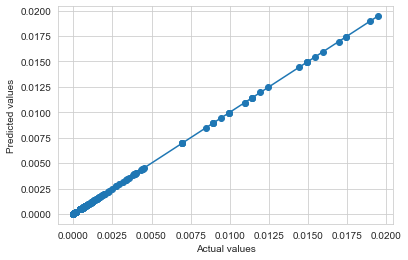

In [96]:
#Regression Plot for Actual vs Predicted values
r_squared = Rsquared
plt.scatter(y_test,y_predLR)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_predLR, 1))(np.unique(y_test)))
plt.show()

In [225]:
#R Square for Linear Regression
Rsquared_LR = metrics.r2_score(y_test, y_predLR)
print ('Training set RSquare: %.2f' % Rsquared_LR)

Training set RSquare: 1.00


In [97]:
#Mean Squared Error for Linear Regression
metrics.mean_squared_error(y_test, y_predLR)

2.835913908543478e-34

In [98]:
#Root Mean Square Error for Linear Regression
rmse_LR = math.sqrt(metrics.mean_squared_error(y_test, y_predLR))
print ('Training set RMSE: %.2f' % rmse_LR)

Training set RMSE: 0.00


In [224]:
#Mean Absolute Error for Linear Regression
mae_LR = metrics.mean_absolute_error(y_test, y_predLR)
print ('Training set MAE: %.2f' % mae_LR)

Training set MAE: 0.00


In [231]:
#Tabulate evaluation results
metrics_LR = pd.DataFrame([['RSquare', Rsquared_LR],['RMSE', rmse_LR], ['MAE', mae_LR]], columns = ['Metric', 'Value'])
metrics_LR

,Metric,Value
0,RSquare,1.000000e+00
1,RMSE,1.684017e-17
2,MAE,1.340580e-17


# Random Forest Regressor

In [101]:
#Randrom Forest Regressor
regressor = RandomForestRegressor(max_depth=2, random_state=0)

In [102]:
#Fit Random Forest Regressor
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [104]:
#Predict target variable using RF
y_predRF = regressor.predict(X_test)


# Evaluation Measures for Random Forest

In [105]:
#Mean Squared Error for RF
metrics.mean_squared_error(y_test, y_predRF)

6.250750492036572e-07

In [226]:
#RSquare for RF
Rsquared_RF = metrics.r2_score(y_test, y_predRF)
print ('Training set RSquare: %.2f' % Rsquared_RF)

Training set RSquare: 0.96


In [186]:
#Mean Absolute Error for RF
mae_RF = metrics.mean_absolute_error(y_test, y_predRF)
mae_RF

0.0005196786469328662

In [109]:
#Root mean square error for RF
rmse_RF = math.sqrt(metrics.mean_squared_error(y_test, y_predRF))
print ('Training set RMSE: %.2f' % rmse_RF)

Training set RMSE: 0.00


In [232]:
#Tabulate Evaluation metrics for RF
metrics_RF = pd.DataFrame([['RSquare', Rsquared_RF],['RMSE', rmse_RF], ['MAE', mae_RF]], columns = ['Metric', 'Value'])
metrics_RF

,Metric,Value
0,RSquare,0.963824
1,RMSE,0.000791
2,MAE,0.000520


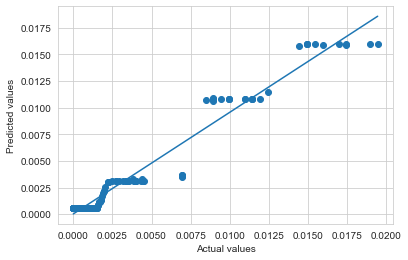

In [110]:
#Regression plot for RF
r_squared = Rsquared_RF
plt.scatter(y_test,y_predRF)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_predRF, 1))(np.unique(y_test)))
plt.show()

# AdaBoost Regressor

In [112]:
#Adaptive Boosting Regressor
Adaregr = AdaBoostRegressor(random_state=0, n_estimators=100)
Adaregr.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [114]:
#Prediction of target variable using AdaBoost
y_predAB = Adaregr.predict(X_test)

In [115]:
#Mean Squared Error for AdaBoost
metrics.mean_squared_error(y_test, y_predAB)

1.4122961138924022e-07

In [227]:
#Rsquare for AdaBoost
Rsquared_AB = metrics.r2_score(y_test, y_predAB)
print ('Training set RSquare: %.2f' % Rsquared_AB)

Training set RSquare: 0.99


In [187]:
#Mean Absolute Error for AdaBoost
mae_AB = metrics.mean_absolute_error(y_test, y_predAB)
mae_AB

0.0002596630778426921

In [119]:
#Root mean square error for AdaBoost
rmse_AB = math.sqrt(metrics.mean_squared_error(y_test, y_predAB))
print ('Training set RMSE: %.2f' % rmse_AB)

Training set RMSE: 0.00


In [234]:
#Tabulate Evaluation metrics for AdaBoost
metrics_AB = pd.DataFrame([['RSquare', Rsquared_AB],['RMSE', rmse_AB], ['MAE', mae_AB]], columns = ['Metric', 'Value'])
metrics_AB

,Metric,Value
0,RSquare,0.991826
1,RMSE,0.000376
2,MAE,0.000260


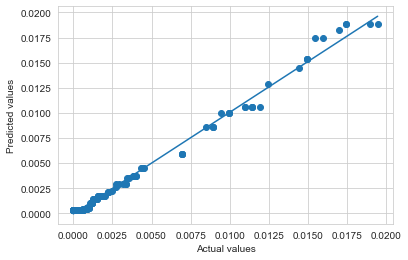

In [120]:
r_squared = Rsquared_AB
plt.scatter(y_test,y_predAB)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_predAB, 1))(np.unique(y_test)))
plt.show()

# XGBoost Regressor

In [122]:
#Extended Gradient Boost Regressor
xgb_r = xg.XGBRegressor(n_estimators = 108, seed = 123)

In [123]:
# Fitting the model 
xgb_r.fit(X_train, y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=108, n_jobs=0, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

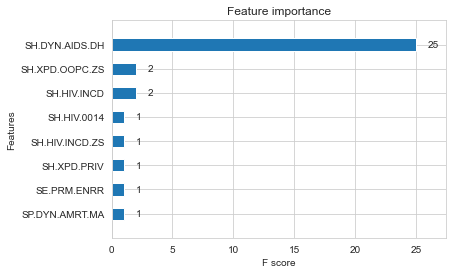

In [124]:
xg.plot_importance(xgb_r, height = .5)

In [125]:
# Predict the model 
y_predXG = xgb_r.predict(X_test)  

In [126]:
# RMSE Computation 
metrics.mean_squared_error(y_test, y_predXG)

2.2705324693228727e-07

In [228]:
#R square for XGBoost
Rsquared_XG = metrics.r2_score(y_test, y_predXG)
print ('Training set RSquare: %.2f' % Rsquared_XG)

Training set RSquare: 0.99


In [188]:
#Mean Absolute Error for XGBoost
mae_XG = metrics.mean_absolute_error(y_test, y_predXG)
mae_XG

0.00018635834763721144

In [129]:
#Root mean square error for XGBoost
rmse_XG = math.sqrt(metrics.mean_squared_error(y_test, y_predXG))
print ('Training set RMSE: %.2f' % rmse_XG)

Training set RMSE: 0.00


In [236]:
metrics_XG = pd.DataFrame([['RSquare', Rsquared_XG],['RMSE', rmse_XG], ['MAE', mae_XG]], columns = ['Metric', 'Value'])
metrics_XG

,Metric,Value
0,RSquare,0.986859
1,RMSE,0.000477
2,MAE,0.000186


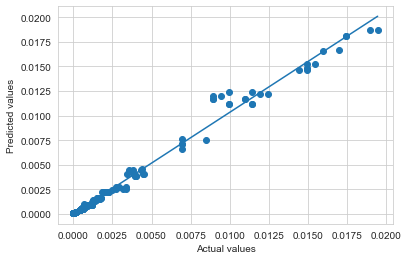

In [130]:
#Regression plot for XGBoost
r_squared = Rsquared_XG
plt.scatter(y_test,y_predXG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_predXG, 1))(np.unique(y_test)))
plt.show()

# Support Vector Regression

In [132]:
#Support Vector Regression
regressor = SVR(kernel='rbf')
regressor.fit(X_train,y_train)

SVR()

In [133]:
#predict target variable
y_predSVR = regressor.predict(X_test)

In [134]:
#Rsquare computation
Rsquared_SVR = metrics.r2_score(y_test, y_predSVR)
Rsquared_SVR

-3.0745687626049563

In [189]:
#Mean Absolute Error 
mae_SVR = metrics.mean_absolute_error(y_test, y_predSVR)
mae_SVR

0.008064069870160175

In [138]:
# MSE Computation 
mse = metrics.mean_squared_error(y_test, y_predSVR)

In [139]:
#RMSE Computation
rmse_SVR = math.sqrt(metrics.mean_squared_error(y_test, y_predSVR))
print ('Training set RMSE: %.2f' % rmse_SVR)

Training set RMSE: 0.01


In [237]:
#Tabulate metrics
metrics_SVR = pd.DataFrame([['RSquare', Rsquared_SVR],['RMSE', rmse_SVR], ['MAE', mae_SVR]], columns = ['Metric', 'Value'])
metrics_SVR

,Metric,Value
0,RSquare,-3.074569
1,RMSE,0.008391
2,MAE,0.008064


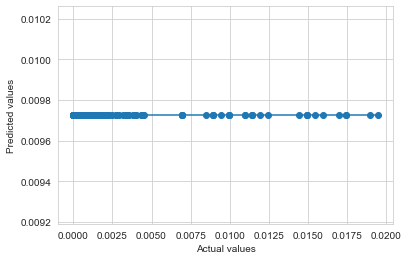

In [140]:
r_squared = Rsquared_SVR
plt.scatter(y_test,y_predSVR)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_predSVR, 1))(np.unique(y_test)))
plt.show()

# Neural Networks (LSTM)

In [147]:
#Long Short-term Memory
model = Sequential()
model.add(LSTM(6, input_shape=(1, 71)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
filepath="weights_best.hdf5"
history = model.fit(X_train.values.reshape(524, 1, 71), y_train, epochs=100, batch_size=6, verbose=2)

Epoch 1/100
88/88 - 0s - loss: 4.4351e-04 - accuracy: 0.1317
Epoch 2/100
88/88 - 0s - loss: 6.4795e-05 - accuracy: 0.1317
Epoch 3/100
88/88 - 0s - loss: 2.9911e-05 - accuracy: 0.1317
Epoch 4/100
88/88 - 0s - loss: 1.9599e-05 - accuracy: 0.1317
Epoch 5/100
88/88 - 0s - loss: 1.5028e-05 - accuracy: 0.1317
Epoch 6/100
88/88 - 0s - loss: 1.2456e-05 - accuracy: 0.1317
Epoch 7/100
88/88 - 0s - loss: 1.0757e-05 - accuracy: 0.1317
Epoch 8/100
88/88 - 0s - loss: 8.8738e-06 - accuracy: 0.1317
Epoch 9/100
88/88 - 0s - loss: 7.6877e-06 - accuracy: 0.1317
Epoch 10/100
88/88 - 0s - loss: 7.4001e-06 - accuracy: 0.1317
Epoch 11/100
88/88 - 0s - loss: 6.3612e-06 - accuracy: 0.1317
Epoch 12/100
88/88 - 0s - loss: 5.8959e-06 - accuracy: 0.1317
Epoch 13/100
88/88 - 0s - loss: 5.7887e-06 - accuracy: 0.1317
Epoch 14/100
88/88 - 0s - loss: 4.8982e-06 - accuracy: 0.1317
Epoch 15/100
88/88 - 0s - loss: 4.9607e-06 - accuracy: 0.1317
Epoch 16/100
88/88 - 0s - loss: 4.6811e-06 - accuracy: 0.1317
Epoch 17/100
88/8

In [148]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [190]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
trainPredict = model.predict(X_train.values.reshape(524, 1, 71))
testPredict = model.predict(X_test.values.reshape(225, 1, 71))
Rsquare_LSTM = r2_score(y_test, testPredict)
rmse_LSTM = math.sqrt(metrics.mean_squared_error(y_test, testPredict))
mae_LSTM = metrics.mean_absolute_error(y_test, testPredict)
print("Mean Squared Error:: %.10f" % mean_squared_error(y_test, testPredict))
print('Variance :: %.10f' % r2_score(y_test, testPredict))
mae_LSTM

Mean Squared Error:: 0.0000009523
Variance :: 0.9448846251


0.0007349683190563299

In [238]:
metrics_LSTM = pd.DataFrame([['RSquare', Rsquare_LSTM],['RMSE', rmse_LSTM], ['MAE', mae_LSTM]], columns = ['Metric', 'Value'])
metrics_LSTM

,Metric,Value
0,RSquare,0.944885
1,RMSE,0.000976
2,MAE,0.000735


In [157]:
#from tabulate import tabulate
Rsquare = pd.DataFrame([['LR', Rsquared_LR], ['RF', Rsquared_RF], ['AdaBoost', Rsquared_AB],['XGBoost', Rsquared_XG],
                ['SVM', Rsquared_SVR], ['LSTM', Rsquare_LSTM]], columns = ['Algorithm', 'RSquare'])
#type(Rsquare )
Rsquare

,Algorithm,RSquare
0,LR,1.000000
1,RF,0.963824
2,AdaBoost,0.991826
3,XGBoost,0.986859
4,SVM,-3.074569
5,LSTM,0.944885


In [158]:
#Root mean square error
RMSE = pd.DataFrame([['LR', rmse_LR], ['RF', rmse_RF], ['AdaBoost', rmse_AB],['XGBoost', rmse_XG],
                ['SVM', rmse_SVR],['LSTM', rmse_LSTM]], columns=['Algorithm', 'RMSE'])
RMSE

,Algorithm,RMSE
0,LR,1.684017e-17
1,RF,7.906169e-04
2,AdaBoost,3.758053e-04
3,XGBoost,4.765010e-04
4,SVM,8.390709e-03
5,LSTM,9.758751e-04


In [192]:
MAE = pd.DataFrame([['LR', mae_LR], ['RF', mae_RF], ['AdaBoost', mae_AB],['XGBoost', mae_XG],
                ['SVM', mae_SVR],['LSTM', mae_LSTM]], columns=['Algorithm', 'MAE'])
MAE

,Algorithm,MAE
0,LR,1.340580e-17
1,RF,5.196786e-04
2,AdaBoost,2.596631e-04
3,XGBoost,1.863583e-04
4,SVM,8.064070e-03
5,LSTM,7.349683e-04


## Here is the comparision of metrics RSquare, RMSE, MAE for each model which we have evaluated above

In [229]:
ScoreComparison = pd.DataFrame([['LR', Rsquared_LR, rmse_LR, mae_LR], ['RF', Rsquared_RF, rmse_RF, mae_RF], 
                ['AdaBoost', Rsquared_AB, rmse_AB, mae_AB],['XGBoost', Rsquared_XG, rmse_XG, mae_XG],
                ['SVM', Rsquared_SVR, rmse_SVR, mae_SVR],['LSTM', Rsquare_LSTM, rmse_LSTM, mae_LSTM]], 
                                 columns=['Algorithm', 'RSquare', 'RMSE', 'MAE'])
ScoreComparison

,Algorithm,RSquare,RMSE,MAE
0,LR,1.000000,1.684017e-17,1.340580e-17
1,RF,0.963824,7.906169e-04,5.196786e-04
2,AdaBoost,0.991826,3.758053e-04,2.596631e-04
3,XGBoost,0.986859,4.765010e-04,1.863583e-04
4,SVM,-3.074569,8.390709e-03,8.064070e-03
5,LSTM,0.944885,9.758751e-04,7.349683e-04


## Here is the comparision of each metric in bar graph for each algorithm

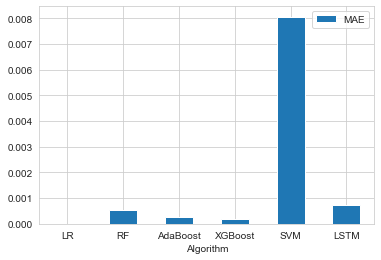

In [193]:
MAE.plot.bar(x = 'Algorithm', y = 'MAE' ,rot=0)

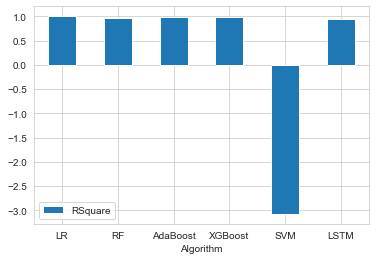

In [194]:
Rsquare.plot.bar(x = 'Algorithm', y = 'RSquare' ,rot=0)

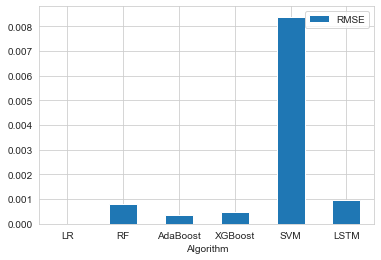

In [160]:
RMSE.plot.bar(x = 'Algorithm', y = 'RMSE', rot=0)

# Prediction of Population Growth

In [240]:
y_PG = featuresExcludingOutliers['SP.POP.GROW']
X_PG = featuresExcludingOutliers.drop(['SP.POP.GROW'], axis = 1)

In [248]:
#Splitting dataset to Train and test with 70 and 30 percentage
X_PG_train, X_PG_test, y_PG_train, y_PG_test = train_test_split(featuresExcludingOutliers, y_PG, test_size=0.30, random_state=42)

# Linear Regression

In [249]:
regr_PG = LinearRegression()
regr_PG.fit(featuresExcludingOutliers, y_PG)

LinearRegression()

In [250]:
print('Intercept: \n', regr_PG.intercept_)
print('Coefficients: \n', regr_PG.coef_)

Intercept: 
 1.1102230246251565e-16
Coefficients: 
 [ 6.08508158e-15 -1.31838984e-16 -2.01227923e-16 -3.46944695e-16
  9.52710133e-15  1.07552856e-16  9.68843061e-16  2.77555756e-16
 -4.30211422e-16 -3.50414142e-16  5.30825384e-16 -9.27036226e-15
 -1.70002901e-15 -3.29597460e-16  3.33066907e-15  1.03389519e-15
  4.85722573e-16 -1.59594560e-16  1.80411242e-16 -6.93889390e-17
  1.94289029e-16 -5.96744876e-16  2.08166817e-17 -1.80411242e-16
 -4.03323208e-16  3.05311332e-16 -4.99600361e-16  5.55111512e-17
 -3.12250226e-16 -4.16333634e-17  2.30718222e-16 -2.56739074e-16
 -1.11022302e-16 -1.06858966e-15 -2.67147415e-16  8.32667268e-17
  5.55111512e-17 -2.35922393e-16  1.52655666e-16  4.71844785e-16
 -6.24500451e-17 -1.11022302e-16 -4.06098766e-15  2.77555756e-17
 -1.38777878e-16 -1.96891115e-15 -4.85722573e-17  1.38777878e-16
 -6.52256027e-16  5.41233725e-16 -4.16333634e-17  1.28369537e-16
  8.53483950e-16 -2.63677968e-16  4.78783679e-16 -1.11022302e-16
 -2.08166817e-16  4.56232274e-16  1.38

In [251]:
y_predLR_PG = regr_PG.predict(X_PG_test)

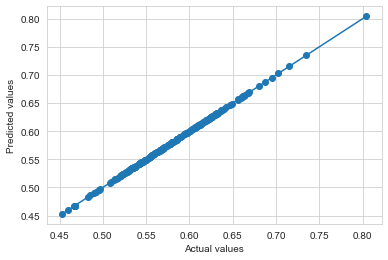

In [253]:
r_squared = Rsquared
plt.scatter(y_PG_test,y_predLR_PG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_PG_test), np.poly1d(np.polyfit(y_PG_test, y_predLR_PG, 1))(np.unique(y_PG_test)))
plt.show()

In [258]:
#R Square for Linear Regression
Rsquared_LR_PG = metrics.r2_score(y_PG_test, y_predLR_PG)
print ('Training set RSquare: %.2f' % Rsquared_LR_PG)

Training set RSquare: 1.00


In [260]:
#Root Mean Square Error for Linear Regression
rmse_LR_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, y_predLR_PG))
print ('Training set RMSE: %.2f' % rmse_LR_PG)

Training set RMSE: 0.00


In [261]:
#Mean Absolute Error for Linear Regression
mae_LR_PG = metrics.mean_absolute_error(y_PG_test, y_predLR_PG)
print ('Training set MAE: %.2f' % mae_LR_PG)

Training set MAE: 0.00


In [262]:
metrics_LR_PG = pd.DataFrame([['RSquare', Rsquared_LR_PG],['RMSE', rmse_LR_PG], ['MAE', mae_LR_PG]], columns = ['Metric', 'Value'])
metrics_LR_PG

,Metric,Value
0,RSquare,1.000000e+00
1,RMSE,1.367273e-16
2,MAE,1.018938e-16


# Random Forest

In [263]:
regressor_PG = RandomForestRegressor(max_depth=2, random_state=0)

In [264]:
regressor_PG.fit(X_PG_train, y_PG_train)
#Predicted values for Random Forest
y_predRF_PG = regressor.predict(X_PG_test)

In [265]:
#Mean Squared Error for Random Forest
metrics.mean_squared_error(y_PG_test, y_predRF_PG)

0.3279060735001159

In [267]:
#R square for Random Forest
Rsquared_RF_PG = metrics.r2_score(y_PG_test, y_predRF_PG)
print ('Training set RSquare: %.2f' % Rsquared_RF_PG)

Training set RSquare: -115.00


In [269]:
#Mean Absolute Error for Random Forest
mae_RF_PG = metrics.mean_absolute_error(y_PG_test, y_predRF_PG)
mae_RF_PG

0.5701572121039016

In [271]:
#RMSE for Random Forest
rmse_RF_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, y_predRF_PG))
print ('Training set RMSE: %.2f' % rmse_RF_PG)

Training set RMSE: 0.57


In [272]:
metrics_RF_PG = pd.DataFrame([['RSquare', Rsquared_RF_PG],['RMSE', rmse_RF_PG], ['MAE', mae_RF_PG]], columns = ['Metric', 'Value'])
metrics_RF_PG

,Metric,Value
0,RSquare,-114.997928
1,RMSE,0.572631
2,MAE,0.570157


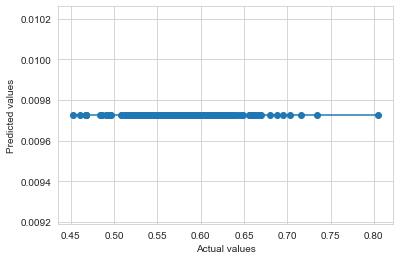

In [289]:
r_squared_PG = Rsquared_RF_PG
plt.scatter(y_PG_test,y_predRF_PG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_PG_test), np.poly1d(np.polyfit(y_PG_test, y_predRF_PG, 1))(np.unique(y_PG_test)))
plt.show()

# AdaBoost Regressor for Population Growth

In [276]:
Adaregr_PG = AdaBoostRegressor(random_state=0, n_estimators=100)
Adaregr_PG.fit(X_PG_train, y_PG_train)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [277]:
y_predAB_PG = Adaregr_PG.predict(X_PG_test)

In [278]:
metrics.mean_squared_error(y_PG_test, y_predAB_PG)

1.927391874779122e-05

In [279]:
Rsquared_AB_PG = metrics.r2_score(y_PG_test, y_predAB_PG)
print ('Training set RSquare: %.2f' % Rsquared_AB_PG)

Training set RSquare: 0.99


In [280]:
y_predAB_PG = Adaregr_PG.predict(X_PG_test)
metrics.mean_squared_error(y_PG_test, y_predAB_PG)
Rsquared_AB_PG = metrics.r2_score(y_PG_test, y_predAB_PG)
print ('Training set RSquare: %.2f' % Rsquared_AB_PG)

Training set RSquare: 0.99


In [281]:
mae_AB_PG = metrics.mean_absolute_error(y_PG_test, y_predAB_PG)
mae_AB_PG

0.002734224172388609

In [283]:
rmse_AB_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, y_predAB_PG))
print ('Training set RMSE: %.5f' % rmse_AB_PG)

Training set RMSE: 0.00439


In [285]:
metrics_AB_PG = pd.DataFrame([['RSquare', Rsquared_AB],['RMSE', rmse_AB], ['MAE', mae_AB]], columns = ['Metric', 'Value'])
metrics_AB_PG

,Metric,Value
0,RSquare,0.991826
1,RMSE,0.000376
2,MAE,0.000260


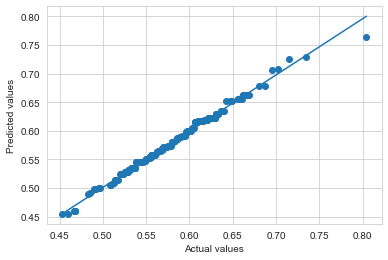

In [288]:
r_squared_PG = Rsquared_AB
plt.scatter(y_PG_test,y_predAB_PG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_PG_test), np.poly1d(np.polyfit(y_PG_test, y_predAB_PG, 1))(np.unique(y_PG_test)))
plt.show()

## XGBoost Regressor

In [290]:
xgb_r_PG = xg.XGBRegressor(n_estimators = 108, seed = 123)

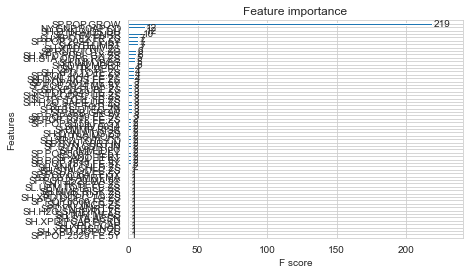

In [293]:
# Fitting the model 
xgb_r_PG.fit(X_PG_train, y_PG_train) 
xg.plot_importance(xgb_r_PG, height = .5)

In [294]:
# Predict the model 
y_predXG_PG = xgb_r_PG.predict(X_PG_test)  

In [295]:
# MSE Computation 
metrics.mean_squared_error(y_PG_test, y_predXG_PG)

4.719591620080216e-06

In [297]:
Rsquared_XG_PG = metrics.r2_score(y_PG_test, y_predXG_PG)
print ('Training set RSquare: %.2f' % Rsquared_XG_PG)

Training set RSquare: 1.00


In [298]:
mae_XG_PG = metrics.mean_absolute_error(y_PG_test, y_predXG_PG)
mae_XG_PG

0.001106154627735229

In [299]:
rmse_XG_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, y_predXG_PG))
print ('Training set RMSE: %.2f' % rmse_XG_PG)

Training set RMSE: 0.00


In [301]:
metrics_XG_PG = pd.DataFrame([['RSquare', Rsquared_XG_PG],['RMSE', rmse_XG_PG], ['MAE', mae_XG_PG]], columns = ['Metric', 'Value'])
metrics_XG_PG

,Metric,Value
0,RSquare,0.998330
1,RMSE,0.002172
2,MAE,0.001106


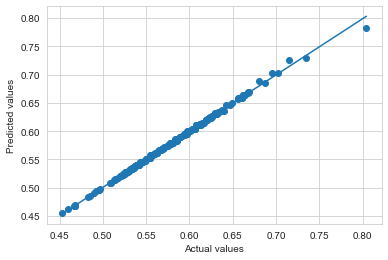

In [305]:
r_squared = Rsquared_XG
plt.scatter(y_PG_test,y_predXG_PG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_PG_test), np.poly1d(np.polyfit(y_PG_test, y_predXG_PG, 1))(np.unique(y_PG_test)))
plt.show()

# Support Vector Regression

In [306]:
regressor_PG = SVR(kernel='rbf')
regressor_PG.fit(X_PG_train,y_PG_train)

SVR()

In [307]:
y_predSVR_PG = regressor.predict(X_PG_test)

In [308]:
Rsquared_SVR_PG = metrics.r2_score(y_PG_test, y_predSVR_PG)
Rsquared_SVR_PG

-114.99792810861263

In [309]:
mae_SVR_PG = metrics.mean_absolute_error(y_PG_test, y_predSVR_PG)
mae_SVR_PG

0.5701572121039016

In [310]:
# MSE Computation 
mse_SVR_PG = metrics.mean_squared_error(y_PG_test, y_predSVR_PG)

In [313]:
rmse_SVR_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, y_predSVR_PG))
print ('Training set RMSE: %.5f' % rmse_SVR)

Training set RMSE: 0.00839


In [314]:
metrics_SVR_PG = pd.DataFrame([['RSquare', Rsquared_SVR_PG],['RMSE', rmse_SVR_PG], ['MAE', mae_SVR_PG]], columns = ['Metric', 'Value'])
metrics_SVR_PG

,Metric,Value
0,RSquare,-114.997928
1,RMSE,0.572631
2,MAE,0.570157


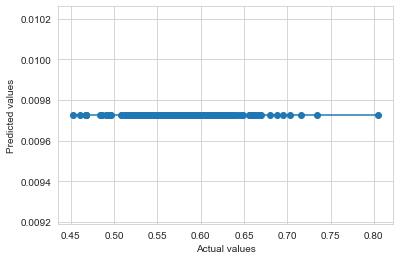

In [316]:
r_squared = Rsquared_SVR_PG
plt.scatter(y_PG_test,y_predSVR_PG)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_PG_test), np.poly1d(np.polyfit(y_PG_test, y_predSVR_PG, 1))(np.unique(y_PG_test)))
plt.show()


# Neural Networks (LSTM)

In [317]:
model = Sequential()
model.add(LSTM(6, input_shape=(1, 71)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
filepath="weights_best.hdf5"
history = model.fit(X_PG_train.values.reshape(524, 1, 71), y_PG_train, epochs=100, batch_size=6, verbose=2)

Epoch 1/100
88/88 - 0s - loss: 0.0741 - accuracy: 0.0000e+00
Epoch 2/100
88/88 - 0s - loss: 0.0039 - accuracy: 0.0000e+00
Epoch 3/100
88/88 - 0s - loss: 0.0023 - accuracy: 0.0000e+00
Epoch 4/100
88/88 - 0s - loss: 0.0016 - accuracy: 0.0000e+00
Epoch 5/100
88/88 - 0s - loss: 0.0014 - accuracy: 0.0000e+00
Epoch 6/100
88/88 - 0s - loss: 0.0012 - accuracy: 0.0000e+00
Epoch 7/100
88/88 - 0s - loss: 0.0011 - accuracy: 0.0000e+00
Epoch 8/100
88/88 - 0s - loss: 0.0010 - accuracy: 0.0000e+00
Epoch 9/100
88/88 - 0s - loss: 9.2568e-04 - accuracy: 0.0000e+00
Epoch 10/100
88/88 - 0s - loss: 8.5517e-04 - accuracy: 0.0000e+00
Epoch 11/100
88/88 - 0s - loss: 7.7755e-04 - accuracy: 0.0000e+00
Epoch 12/100
88/88 - 0s - loss: 7.2185e-04 - accuracy: 0.0000e+00
Epoch 13/100
88/88 - 0s - loss: 6.9568e-04 - accuracy: 0.0000e+00
Epoch 14/100
88/88 - 0s - loss: 6.4660e-04 - accuracy: 0.0000e+00
Epoch 15/100
88/88 - 0s - loss: 6.1181e-04 - accuracy: 0.0000e+00
Epoch 16/100
88/88 - 0s - loss: 5.7189e-04 - accura

In [318]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [319]:
trainPredict_PG = model.predict(X_PG_train.values.reshape(524, 1, 71))
testPredict_PG = model.predict(X_PG_test.values.reshape(225, 1, 71))
Rsquare_LSTM_PG = r2_score(y_PG_test, testPredict_PG)
rmse_LSTM_PG = math.sqrt(metrics.mean_squared_error(y_PG_test, testPredict_PG))
mae_LSTM_PG = metrics.mean_absolute_error(y_PG_test, testPredict_PG)
print("Mean Squared Error:: %.10f" % mean_squared_error(y_PG_test, testPredict_PG))
#print('Variance :: %.10f)

Mean Squared Error:: 0.0000576300


In [320]:
#from tabulate import tabulate
Rsquare_PG = pd.DataFrame([['LR', Rsquared_LR_PG], ['RF', Rsquared_RF_PG], ['AdaBoost', Rsquared_AB_PG],['XGBoost', Rsquared_XG_PG],
                ['SVM', Rsquared_SVR_PG], ['LSTM', Rsquare_LSTM_PG]], columns = ['Algorithm', 'RSquare'])
#type(Rsquare )
Rsquare_PG

,Algorithm,RSquare
0,LR,1.000000
1,RF,-114.997928
2,AdaBoost,0.993182
3,XGBoost,0.998330
4,SVM,-114.997928
5,LSTM,0.979613


In [321]:
RMSE_PG = pd.DataFrame([['LR', rmse_LR_PG], ['RF', rmse_RF_PG], ['AdaBoost', rmse_AB_PG],['XGBoost', rmse_XG_PG],
                ['SVM', rmse_SVR_PG],['LSTM', rmse_LSTM_PG]], columns=['Algorithm', 'RMSE'])
RMSE_PG

,Algorithm,RMSE
0,LR,1.367273e-16
1,RF,5.726308e-01
2,AdaBoost,4.390207e-03
3,XGBoost,2.172462e-03
4,SVM,5.726308e-01
5,LSTM,7.591443e-03


In [322]:
MAE_PG = pd.DataFrame([['LR', mae_LR_PG], ['RF', mae_RF_PG], ['AdaBoost', mae_AB_PG],['XGBoost', mae_XG_PG],
                ['SVM', mae_SVR_PG],['LSTM', mae_LSTM_PG]], columns=['Algorithm', 'MAE'])
MAE_PG

,Algorithm,MAE
0,LR,1.018938e-16
1,RF,5.701572e-01
2,AdaBoost,2.734224e-03
3,XGBoost,1.106155e-03
4,SVM,5.701572e-01
5,LSTM,5.485394e-03


In [324]:
ScoreComparison_PG = pd.DataFrame([['LR', Rsquared_LR_PG, rmse_LR_PG, mae_LR_PG], ['RF', Rsquared_RF_PG, rmse_RF_PG, mae_RF_PG], 
                ['AdaBoost', Rsquared_AB_PG, rmse_AB_PG, mae_AB_PG],['XGBoost', Rsquared_XG_PG, rmse_XG_PG, mae_XG_PG],
                ['SVM', Rsquared_SVR_PG, rmse_SVR_PG, mae_SVR_PG],['LSTM', Rsquare_LSTM_PG, rmse_LSTM_PG, mae_LSTM_PG]], 
                                 columns=['Algorithm', 'RSquare', 'RMSE', 'MAE'])
ScoreComparison_PG

,Algorithm,RSquare,RMSE,MAE
0,LR,1.000000,1.367273e-16,1.018938e-16
1,RF,-114.997928,5.726308e-01,5.701572e-01
2,AdaBoost,0.993182,4.390207e-03,2.734224e-03
3,XGBoost,0.998330,2.172462e-03,1.106155e-03
4,SVM,-114.997928,5.726308e-01,5.701572e-01
5,LSTM,0.979613,7.591443e-03,5.485394e-03


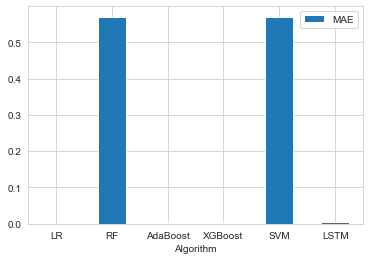

In [326]:
MAE_PG.plot.bar(x = 'Algorithm', y = 'MAE' ,rot=0)

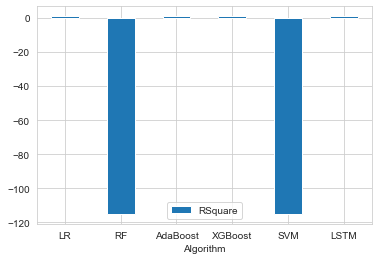

In [327]:
Rsquare_PG.plot.bar(x = 'Algorithm', y = 'RSquare' ,rot=0)

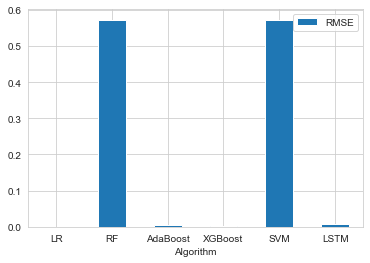

In [329]:
RMSE_PG.plot.bar(x = 'Algorithm', y = 'RMSE', rot=0)